# Business Case 3 - Recommender System

- Emanuele Aldera, m20210617
- Robin Schmidt, m20210602
- Muhammad Abdullah, m20210655
- Rui Ramos, m20210640

## Importing Libraries and Dataset

In [175]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil 
from datetime import datetime
# %pip install abc_analysis
from abc_analysis import abc_analysis
from mlxtend.frequent_patterns import apriori, association_rules
from tabulate import tabulate

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.model_selection import train_test_split
import turicreate as tc

import warnings
warnings.filterwarnings("ignore")

In [176]:
data = pd.read_csv("retail.csv")
data_orig = data.copy()
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


In [177]:
data["InvoiceDate"] = pd.to_datetime(data["InvoiceDate"])
data["Year"] = data["InvoiceDate"].dt.year
data["Month"] = data["InvoiceDate"].dt.month
# data["MonthName"] = data["InvoiceDate"].dt.month_name()
data["Day"] = data["InvoiceDate"].dt.day
data["Weekday"] = data["InvoiceDate"].dt.weekday +1
data["WeekdayName"] = data["InvoiceDate"].dt.day_name()
data["IsWeekend"] = data["Weekday"] > 5
data["Time"] = data["InvoiceDate"].dt.time
data["Hour"] = data["InvoiceDate"].dt.hour
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 16 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
 8   Year         541909 non-null  int64         
 9   Month        541909 non-null  int64         
 10  Day          541909 non-null  int64         
 11  Weekday      541909 non-null  int64         
 12  WeekdayName  541909 non-null  object        
 13  IsWeekend    541909 non-null  bool          
 14  Time         541909 non-null  object        
 15  Hour         541909 non-null  int6

In [178]:
def f(x):
    if (x > 4) and (x <= 8):
        return 'Early Morning'
    elif (x > 8) and (x <= 12 ):
        return 'Morning'
    elif (x > 12) and (x <= 16):
        return'Noon'
    elif (x > 16) and (x <= 20) :
        return 'Eve'
    elif (x > 20) and (x <= 24):
        return'Night'
    elif (x <= 4):
        return'Late Night'

prods = pd.DataFrame({'hour':range(1, 25)})

b = [0,4,8,12,16,20,24]
l = ['Late Night', 'Early Morning','Morning','Noon','Eve','Night']
prods['session'] = pd.cut(prods['hour'], bins=b, labels=l, include_lowest=True)

data["DayTime"] = data['Hour'].apply(f)

In [179]:
prods = pd.DataFrame({'hour':range(1, 25)})

b = [0,4,8,12,16,20,24]
l = ['Late Night', 'Early Morning','Morning','Noon','Eve','Night']
prods['session'] = pd.cut(prods['hour'], bins=b, labels=l, include_lowest=True)

In [180]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0
Year,541909.0,2010.921609,0.268787,2010.00,2011.00,2011.00,2011.00,2011.0
Month,541909.0,7.553128,3.509055,1.00,5.00,8.00,11.00,12.0
Day,541909.0,15.023096,8.664063,1.00,7.00,15.00,22.00,31.0
Weekday,541909.0,3.431277,1.844709,1.00,2.00,3.00,5.00,7.0
Hour,541909.0,13.078729,2.443270,6.00,11.00,13.00,15.00,20.0


## Data exploration

Business understanding

In [181]:
#Counting the important features to have the notion of the dimension
print('The number of countries is:', data.Country.nunique())
print('The number of customers with observations is:', data.CustomerID.nunique())
print('The number of Products with transactions is:', data.Description.nunique())

The number of countries is: 38
The number of customers with observations is: 4372
The number of Products with transactions is: 4223


In [182]:
table1 = [['N. Countries', 'N. customers', 'N. Products'],[data.Country.nunique(), data.CustomerID.nunique(), data.Description.nunique()]]
print(tabulate(table1, headers='firstrow', tablefmt='fancy_grid'))

╒════════════════╤════════════════╤═══════════════╕
│   N. Countries │   N. customers │   N. Products │
╞════════════════╪════════════════╪═══════════════╡
│             38 │           4372 │          4223 │
╘════════════════╧════════════════╧═══════════════╛


In [183]:
def boxplot (data):
    from math import ceil

    metric_features = data.select_dtypes(include=np.number).set_index(data.index).columns
    sns.set()
    
    fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(20, 11))

    
    for ax, feat in zip(axes.flatten(), metric_features): 

        sns.boxplot(x = data[feat], ax = ax)
        

    
    title = "Numeric Variables' Boxplots"

    plt.suptitle(title)

    plt.show()

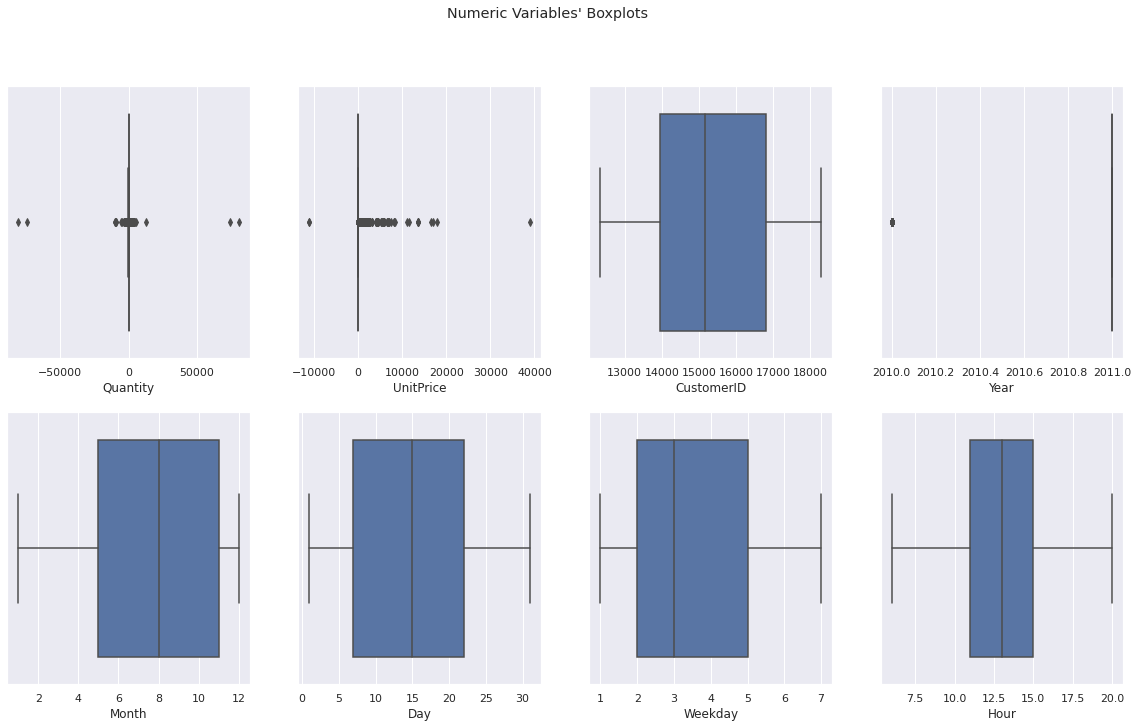

In [184]:
numeric_features = data.select_dtypes(include=np.number).set_index(data.index).columns.tolist()
boxplot(data[numeric_features])

In [185]:
#removing "outliers"
data = data[data["Quantity"]<10000]
data = data[data["UnitPrice"]<600]

Cancelations

In [186]:
cancelations = data.loc[data["InvoiceNo"].str.contains("C")]
cancelations

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,Weekday,WeekdayName,IsWeekend,Time,Hour,DayTime
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom,2010,12,1,3,Wednesday,False,09:41:00,9,Morning
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom,2010,12,1,3,Wednesday,False,09:49:00,9,Morning
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,2010,12,1,3,Wednesday,False,10:24:00,10,Morning
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,2010,12,1,3,Wednesday,False,10:24:00,10,Morning
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,2010,12,1,3,Wednesday,False,10:24:00,10,Morning
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom,2011,12,9,5,Friday,False,09:57:00,9,Morning
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom,2011,12,9,5,Friday,False,10:28:00,10,Morning
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom,2011,12,9,5,Friday,False,11:57:00,11,Morning
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom,2011,12,9,5,Friday,False,11:58:00,11,Morning


In [187]:
#check consistency for cancelations, we shouldnt have any cancelations with quantity > 0
cancelations.loc[cancelations["Quantity"] > 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,Weekday,WeekdayName,IsWeekend,Time,Hour,DayTime


In [188]:
#check if for cancellations we have also the non cancelled record
cancelations2 = cancelations.copy()

#deleting C into cancelled invoices to have a joinable column to original df
cancelations2["InvoiceNo"] = cancelations2["InvoiceNo"].str.replace("C", "")

#results finds 0 records --> no duplicated records
pd.merge(left = data, right = cancelations2, how = "inner", on = "InvoiceNo")

,InvoiceNo,StockCode_x,Description_x,Quantity_x,InvoiceDate_x,UnitPrice_x,CustomerID_x,Country_x,Year_x,Month_x,...,Country_y,Year_y,Month_y,Day_y,Weekday_y,WeekdayName_y,IsWeekend_y,Time_y,Hour_y,DayTime_y


In [189]:
#removing from dataset cancelations
data = data[data["Quantity"] >= 0]

Missing values

In [190]:
data.isna().sum(axis = 0)

InvoiceNo           0
StockCode           0
Description       592
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     133274
Country             0
Year                0
Month               0
Day                 0
Weekday             0
WeekdayName         0
IsWeekend           0
Time                0
Hour                0
DayTime             0
dtype: int64

In [191]:
#showing records not having customer id
data[data.CustomerID.isna()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,Weekday,WeekdayName,IsWeekend,Time,Hour,DayTime
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,NaN,United Kingdom,2010,12,1,3,Wednesday,False,11:52:00,11,Morning
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom,2010,12,1,3,Wednesday,False,14:32:00,14,Noon
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom,2010,12,1,3,Wednesday,False,14:32:00,14,Noon
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,NaN,United Kingdom,2010,12,1,3,Wednesday,False,14:32:00,14,Noon
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom,2010,12,1,3,Wednesday,False,14:32:00,14,Noon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541535,581498,85049e,SCANDINAVIAN REDS RIBBONS,4,2011-12-09 10:26:00,3.29,NaN,United Kingdom,2011,12,9,5,Friday,False,10:26:00,10,Morning
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,2011-12-09 10:26:00,4.13,NaN,United Kingdom,2011,12,9,5,Friday,False,10:26:00,10,Morning
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,2011-12-09 10:26:00,4.13,NaN,United Kingdom,2011,12,9,5,Friday,False,10:26:00,10,Morning
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,2011-12-09 10:26:00,4.96,NaN,United Kingdom,2011,12,9,5,Friday,False,10:26:00,10,Morning


In [192]:
# number of invoices not having at least one missing customer id value
len(data[data.CustomerID.isna()]["InvoiceNo"].unique())

2182

Data Consistency

In [193]:
#checking dataset consistency - for each invoice only one customer id associated
grouped = data.groupby("InvoiceNo")["CustomerID"].nunique(dropna=False)
grouped.sort_values(ascending = False)

InvoiceNo
A563187    1
551872     1
551896     1
551897     1
551900     1
          ..
566818     1
566819     1
566821     1
566822     1
536365     1
Name: CustomerID, Length: 20695, dtype: int64

In [194]:
#checking dataset consistency - for each stock code only one description associated
grouped = data.groupby("StockCode")["Description"].nunique(dropna=False)
grouped.sort_values(ascending = False)

StockCode
20713    7
23084    7
21181    5
22734    5
22837    4
        ..
35651    1
35650    1
35649    1
35648    1
23111    1
Name: Description, Length: 3940, dtype: int64

In [195]:
# by looking at results we decide not to take care of this issue, we just use stock code
data[data["StockCode"] == "20713"]["Description"].unique()

array(['JUMBO BAG OWLS', nan, 'found', 'Found', 'wrongly marked 23343',
       'Marked as 23343', 'wrongly coded 23343'], dtype=object)

Taking care of stock codes not associated to products

In [196]:
print("Value counts of StockCodes with string lenght minor than 5")
print(data[data["StockCode"].str.len()<5].value_counts("StockCode"))
print()
print("Description associated")
print(data[data["StockCode"].str.len()<5].value_counts("Description"))

Value counts of StockCodes with string lenght minor than 5
StockCode
POST    1128
DOT      625
M        296
C2       142
PADS       4
S          2
B          2
m          1
dtype: int64

Description associated
Description
POSTAGE                       1124
DOTCOM POSTAGE                 624
Manual                         297
CARRIAGE                       141
PADS TO MATCH ALL CUSHIONS       4
SAMPLES                          2
Adjust bad debt                  2
dtype: int64


In [197]:
# deleting stock codes with len < 5 ()
del_stockcodes = data[data["StockCode"].str.len()<5].StockCode.unique().tolist()
data = data[~data["StockCode"].isin(del_stockcodes)]

Items with price associated 0

In [198]:
# quick look on invoices having cost 0
data[data.UnitPrice == 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,Weekday,WeekdayName,IsWeekend,Time,Hour,DayTime
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.0,NaN,United Kingdom,2010,12,1,3,Wednesday,False,11:52:00,11,Morning
1970,536545,21134,NaN,1,2010-12-01 14:32:00,0.0,NaN,United Kingdom,2010,12,1,3,Wednesday,False,14:32:00,14,Noon
1971,536546,22145,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom,2010,12,1,3,Wednesday,False,14:33:00,14,Noon
1972,536547,37509,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom,2010,12,1,3,Wednesday,False,14:33:00,14,Noon
1987,536549,85226A,NaN,1,2010-12-01 14:34:00,0.0,NaN,United Kingdom,2010,12,1,3,Wednesday,False,14:34:00,14,Noon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535334,581211,22142,check,14,2011-12-07 18:36:00,0.0,NaN,United Kingdom,2011,12,7,3,Wednesday,False,18:36:00,18,Eve
536981,581234,72817,NaN,27,2011-12-08 10:33:00,0.0,NaN,United Kingdom,2011,12,8,4,Thursday,False,10:33:00,10,Morning
538504,581406,46000M,POLYESTER FILLER PAD 45x45cm,240,2011-12-08 13:58:00,0.0,NaN,United Kingdom,2011,12,8,4,Thursday,False,13:58:00,13,Noon
538505,581406,46000S,POLYESTER FILLER PAD 40x40cm,300,2011-12-08 13:58:00,0.0,NaN,United Kingdom,2011,12,8,4,Thursday,False,13:58:00,13,Noon


In [199]:
#number of products having unit price to 0
print("# of rows having price 0 : ", len(data[data.UnitPrice == 0]))
print("# of products having price 0 : ", len(data[data.UnitPrice == 0]["StockCode"].unique()))

# of rows having price 0 :  1163
# of products having price 0 :  675


In [200]:
#Reducing cardinality for Country
data.loc[data["Country"].value_counts()[data["Country"]].values < 500, "Country"] = "Others"

Duplicates

In [201]:
data_dup = data.copy()
print("Percentage of suspect duplicated data: " , (data_orig.duplicated(["StockCode", "InvoiceNo"]).sum() / len(data)) * 100)

Percentage of suspect duplicated data:  2.01980864373744


In [202]:
duplicates = data_dup.loc[data_dup.duplicated()]
duplicates = duplicates.groupby(duplicates.columns.tolist(),as_index=False).size().sort_values("size", ascending = False)
size = duplicates.pop("size")
duplicates.insert(0, "size", size)
duplicates

,size,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,Weekday,WeekdayName,IsWeekend,Time,Hour,DayTime
1596,19,555524,22698,PINK REGENCY TEACUP AND SAUCER,1,2011-06-05 11:37:00,2.95,16923.0,United Kingdom,2011,6,5,7,Sunday,True,11:37:00,11,Morning
1595,11,555524,22697,GREEN REGENCY TEACUP AND SAUCER,1,2011-06-05 11:37:00,2.95,16923.0,United Kingdom,2011,6,5,7,Sunday,True,11:37:00,11,Morning
3170,7,572861,22775,PURPLE DRAWERKNOB ACRYLIC EDWARDIAN,12,2011-10-26 12:46:00,1.25,14102.0,United Kingdom,2011,10,26,3,Wednesday,False,12:46:00,12,Morning
346,5,538514,21756,BATH BUILDING BLOCK WORD,1,2010-12-12 14:27:00,5.95,15044.0,United Kingdom,2010,12,12,7,Sunday,True,14:27:00,14,Noon
470,5,540524,21756,BATH BUILDING BLOCK WORD,1,2011-01-09 12:53:00,5.95,16735.0,United Kingdom,2011,1,9,7,Sunday,True,12:53:00,12,Morning
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1659,1,556280,22500,SET OF 2 TINS JARDIN DE PROVENCE,1,2011-06-09 20:03:00,4.95,14584.0,United Kingdom,2011,6,9,4,Thursday,False,20:03:00,20,Eve
1658,1,556280,22497,SET OF 2 TINS VINTAGE BATHROOM,1,2011-06-09 20:03:00,4.25,14584.0,United Kingdom,2011,6,9,4,Thursday,False,20:03:00,20,Eve
1657,1,556263,23242,TREASURE TIN BUFFALO BILL,1,2011-06-09 18:41:00,2.08,13969.0,United Kingdom,2011,6,9,4,Thursday,False,18:41:00,18,Eve
1656,1,556252,84970S,HANGING HEART ZINC T-LIGHT HOLDER,12,2011-06-09 16:44:00,0.85,16779.0,United Kingdom,2011,6,9,4,Thursday,False,16:44:00,16,Noon


In [203]:
data[(data.InvoiceNo == "555524") & (data.StockCode == "22698")]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,Weekday,WeekdayName,IsWeekend,Time,Hour,DayTime
213176,555524,22698,PINK REGENCY TEACUP AND SAUCER,1,2011-06-05 11:37:00,2.95,16923.0,United Kingdom,2011,6,5,7,Sunday,True,11:37:00,11,Morning
213177,555524,22698,PINK REGENCY TEACUP AND SAUCER,1,2011-06-05 11:37:00,2.95,16923.0,United Kingdom,2011,6,5,7,Sunday,True,11:37:00,11,Morning
213183,555524,22698,PINK REGENCY TEACUP AND SAUCER,1,2011-06-05 11:37:00,2.95,16923.0,United Kingdom,2011,6,5,7,Sunday,True,11:37:00,11,Morning
213191,555524,22698,PINK REGENCY TEACUP AND SAUCER,1,2011-06-05 11:37:00,2.95,16923.0,United Kingdom,2011,6,5,7,Sunday,True,11:37:00,11,Morning
213192,555524,22698,PINK REGENCY TEACUP AND SAUCER,1,2011-06-05 11:37:00,2.95,16923.0,United Kingdom,2011,6,5,7,Sunday,True,11:37:00,11,Morning
213194,555524,22698,PINK REGENCY TEACUP AND SAUCER,1,2011-06-05 11:37:00,2.95,16923.0,United Kingdom,2011,6,5,7,Sunday,True,11:37:00,11,Morning
213195,555524,22698,PINK REGENCY TEACUP AND SAUCER,1,2011-06-05 11:37:00,2.95,16923.0,United Kingdom,2011,6,5,7,Sunday,True,11:37:00,11,Morning
213196,555524,22698,PINK REGENCY TEACUP AND SAUCER,1,2011-06-05 11:37:00,2.95,16923.0,United Kingdom,2011,6,5,7,Sunday,True,11:37:00,11,Morning
213197,555524,22698,PINK REGENCY TEACUP AND SAUCER,1,2011-06-05 11:37:00,2.95,16923.0,United Kingdom,2011,6,5,7,Sunday,True,11:37:00,11,Morning
213198,555524,22698,PINK REGENCY TEACUP AND SAUCER,1,2011-06-05 11:37:00,2.95,16923.0,United Kingdom,2011,6,5,7,Sunday,True,11:37:00,11,Morning


In [204]:
#replacing duplicates with single record containing sum of all quantities for records that are going to be deleted
# tested, it works
data['Quantity'] = data.groupby(['InvoiceNo', 'StockCode'])['Quantity'].transform('sum')
data = data.drop_duplicates(subset=['InvoiceNo', 'StockCode'])

In [205]:
data[(data.InvoiceNo == "555524") & (data.StockCode == "22698")]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,Weekday,WeekdayName,IsWeekend,Time,Hour,DayTime
213176,555524,22698,PINK REGENCY TEACUP AND SAUCER,20,2011-06-05 11:37:00,2.95,16923.0,United Kingdom,2011,6,5,7,Sunday,True,11:37:00,11,Morning


In [206]:
data["TotalPrice"] = data["UnitPrice"] * data["Quantity"]

ABC segmentation

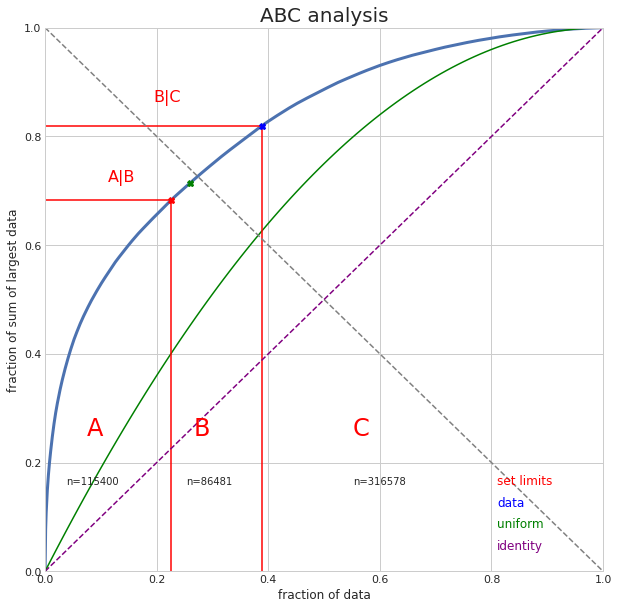

{'ABLimit': 19.5,
 'BCLimit': 14.040000000000001,
 'ABexchanged': True,
 'Aind': [1,
  2,
  3,
  4,
  6,
  9,
  12,
  14,
  16,
  19,
  20,
  21,
  26,
  27,
  28,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  39,
  40,
  41,
  44,
  45,
  49,
  50,
  51,
  57,
  60,
  61,
  63,
  64,
  66,
  67,
  68,
  74,
  77,
  78,
  80,
  81,
  82,
  87,
  89,
  90,
  95,
  100,
  101,
  104,
  105,
  106,
  110,
  111,
  137,
  138,
  140,
  141,
  143,
  144,
  145,
  147,
  148,
  149,
  150,
  152,
  153,
  155,
  156,
  157,
  159,
  162,
  163,
  164,
  166,
  171,
  172,
  173,
  174,
  175,
  176,
  177,
  178,
  185,
  190,
  191,
  192,
  193,
  194,
  196,
  197,
  198,
  205,
  206,
  208,
  210,
  211,
  212,
  213,
  214,
  215,
  216,
  217,
  218,
  219,
  220,
  221,
  222,
  223,
  224,
  225,
  226,
  227,
  228,
  229,
  230,
  235,
  238,
  239,
  241,
  243,
  244,
  245,
  246,
  247,
  248,
  249,
  250,
  251,
  252,
  253,
  254,
  258,
  261,
  262,
  263,
  264,
  265,
 

In [207]:
abc_transactions = abc_analysis(data["TotalPrice"], True, fltSize=10)

# index position of A, B, and C for transactions
transaction_a_index = abc_transactions['Aind']
transaction_b_index = abc_transactions['Bind']
transaction_c_index = abc_transactions['Cind']

# New Column indicating A, B, or C
condition = [data.index.isin(transaction_a_index),
             data.index.isin(transaction_b_index),
             data.index.isin(transaction_c_index)]

segment_list = ['A','B','C']

data['Transaction_ABC'] = np.select(condition, segment_list)
data.sort_values(by=['TotalPrice'], ascending=True)
abc_transactions

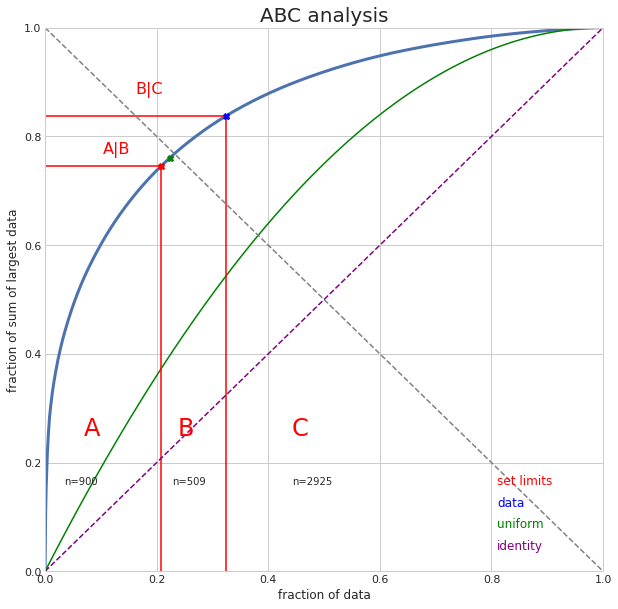

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,Weekday,WeekdayName,IsWeekend,Time,Hour,DayTime,TotalPrice,Transaction_ABC,Customer_ABC
41492,539856,22372,AIRLINE BAG VINTAGE WORLD CHAMPION,1,2010-12-22 14:41:00,0.00,NaN,United Kingdom,2010,12,22,3,Wednesday,False,14:41:00,14,Noon,0.00,C,0
299545,563106,21658,NaN,3,2011-08-12 10:15:00,0.00,NaN,United Kingdom,2011,8,12,5,Friday,False,10:15:00,10,Morning,0.00,C,0
175253,551900,20778,NaN,2,2011-05-05 10:45:00,0.00,NaN,United Kingdom,2011,5,5,4,Thursday,False,10:45:00,10,Morning,0.00,C,0
160541,550460,47556B,did a credit and did not tick ret,1300,2011-04-18 13:18:00,0.00,NaN,United Kingdom,2011,4,18,1,Monday,False,13:18:00,13,Noon,0.00,A,0
299550,563108,21033,NaN,37,2011-08-12 10:18:00,0.00,NaN,United Kingdom,2011,8,12,5,Friday,False,10:18:00,10,Morning,0.00,C,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52709,540815,85123A,WHITE HANGING HEART T-LIGHT HOLDER,1930,2011-01-11 12:55:00,2.55,15749.0,United Kingdom,2011,1,11,2,Tuesday,False,12:55:00,12,Morning,4921.50,C,A
421601,573003,23084,RABBIT NIGHT LIGHT,2400,2011-10-27 12:11:00,2.08,14646.0,Netherlands,2011,10,27,4,Thursday,False,12:11:00,12,Morning,4992.00,A,A
52711,540815,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,2011-01-11 12:55:00,2.10,15749.0,United Kingdom,2011,1,11,2,Tuesday,False,12:55:00,12,Morning,6539.40,C,A
160546,550461,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,2011-04-18 13:20:00,2.10,15749.0,United Kingdom,2011,4,18,1,Monday,False,13:20:00,13,Noon,6539.40,C,A


In [208]:
customer_values = data[["CustomerID", "TotalPrice"]].groupby("CustomerID").sum("TotalPrice").sort_values("TotalPrice", ascending = False)
abc_customers = abc_analysis(customer_values["TotalPrice"], True, fltSize=10)

# index position of A, B, and C for transactions
customer_a_index = customer_values.iloc[abc_customers['Aind']].index
customer_b_index = customer_values.iloc[abc_customers['Bind']].index
customer_c_index = customer_values.iloc[abc_customers['Cind']].index

# New Column indicating A, B, or C
condition = [data["CustomerID"].isin(customer_a_index),
             data["CustomerID"].isin(customer_b_index),
             data["CustomerID"].isin(customer_c_index)]

segment_list = ['A','B','C']

data['Customer_ABC'] = np.select(condition, segment_list)
data.sort_values(by=['TotalPrice'], ascending=True)

# BEWARE WE HAVE SOME NaNs for these values --> might not be the most accurate classification

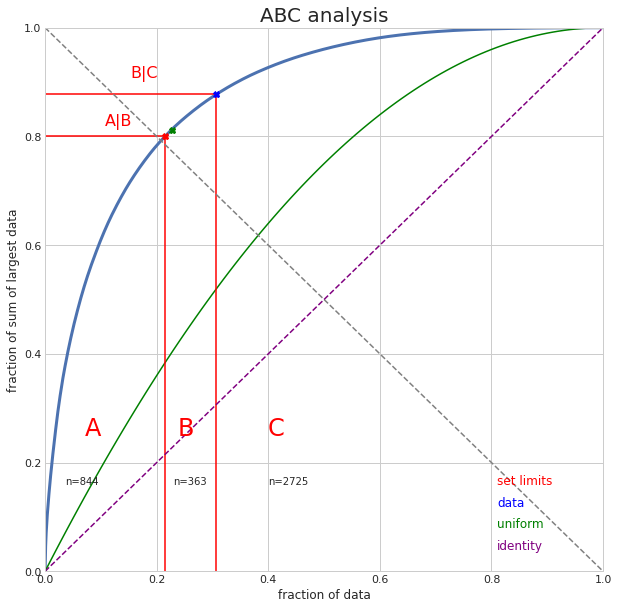

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,...,Weekday,WeekdayName,IsWeekend,Time,Hour,DayTime,TotalPrice,Transaction_ABC,Customer_ABC,Product_ABC
41492,539856,22372,AIRLINE BAG VINTAGE WORLD CHAMPION,1,2010-12-22 14:41:00,0.00,NaN,United Kingdom,2010,12,...,3,Wednesday,False,14:41:00,14,Noon,0.00,C,0,C
299545,563106,21658,NaN,3,2011-08-12 10:15:00,0.00,NaN,United Kingdom,2011,8,...,5,Friday,False,10:15:00,10,Morning,0.00,C,0,A
175253,551900,20778,NaN,2,2011-05-05 10:45:00,0.00,NaN,United Kingdom,2011,5,...,4,Thursday,False,10:45:00,10,Morning,0.00,C,0,C
160541,550460,47556B,did a credit and did not tick ret,1300,2011-04-18 13:18:00,0.00,NaN,United Kingdom,2011,4,...,1,Monday,False,13:18:00,13,Noon,0.00,A,0,A
299550,563108,21033,NaN,37,2011-08-12 10:18:00,0.00,NaN,United Kingdom,2011,8,...,5,Friday,False,10:18:00,10,Morning,0.00,C,0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52709,540815,85123A,WHITE HANGING HEART T-LIGHT HOLDER,1930,2011-01-11 12:55:00,2.55,15749.0,United Kingdom,2011,1,...,2,Tuesday,False,12:55:00,12,Morning,4921.50,C,A,A
421601,573003,23084,RABBIT NIGHT LIGHT,2400,2011-10-27 12:11:00,2.08,14646.0,Netherlands,2011,10,...,4,Thursday,False,12:11:00,12,Morning,4992.00,A,A,A
52711,540815,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,2011-01-11 12:55:00,2.10,15749.0,United Kingdom,2011,1,...,2,Tuesday,False,12:55:00,12,Morning,6539.40,C,A,A
160546,550461,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,2011-04-18 13:20:00,2.10,15749.0,United Kingdom,2011,4,...,1,Monday,False,13:20:00,13,Noon,6539.40,C,A,A


In [209]:
product_values = data[["TotalPrice", "StockCode"]].groupby("StockCode").sum("TotalPrice").sort_values("TotalPrice", ascending = False)
abc_products = abc_analysis(product_values["TotalPrice"], True, fltSize=10)

# # # index position of A, B, and C for transactions
product_a_index = product_values.iloc[abc_products['Aind']].index
product_b_index = product_values.iloc[abc_products['Bind']].index
product_c_index = product_values.iloc[abc_products['Cind']].index

# # New Column indicating A, B, or C
condition = [data["StockCode"].isin(product_a_index),
             data["StockCode"].isin(product_b_index),
             data["StockCode"].isin(product_c_index)]

segment_list = ['A','B','C']

data['Product_ABC'] = np.select(condition, segment_list)
data.sort_values(by=['TotalPrice'], ascending=True)

## A priori algorithm

In [210]:
basket = (data.groupby(['InvoiceNo', 'StockCode'])['Quantity']
        .sum().unstack().reset_index().fillna(0)
        .set_index('InvoiceNo'))
basket

# Transactions done in France
basket_France = (data[data['Country'] =="France"]
        .groupby(['InvoiceNo', 'StockCode'])['Quantity']
        .sum().unstack().reset_index().fillna(0)
        .set_index('InvoiceNo'))

In [211]:
def hot_encode(x):
    if(x<= 0):
        return 0
    if(x>= 1):
        return 1

# basket = basket.applymap(hot_encode)
# basket
basket_France = basket_France.applymap(hot_encode)

In [212]:
# frq_items = apriori(basket, min_support = 0.03, use_colnames = True)
frq_items = apriori(basket_France, min_support = 0.05, use_colnames = True)

In [213]:
rules = association_rules(frq_items, metric ="lift", min_threshold = 1)
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])

rules.head(16)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
68,"(21086, 21080)",(21094),0.104712,0.130890,0.102094,0.975000,7.449000,0.088388,34.764398
70,"(21080, 21094)",(21086),0.104712,0.141361,0.102094,0.975000,6.897222,0.087292,34.345550
25,(21094),(21086),0.130890,0.141361,0.125654,0.960000,6.791111,0.107152,21.465969
67,(23256),(23254),0.070681,0.073298,0.065445,0.925926,12.632275,0.060264,12.510471
35,(21988),(21987),0.057592,0.065445,0.052356,0.909091,13.890909,0.048587,10.280105
66,(23254),(23256),0.073298,0.070681,0.065445,0.892857,12.632275,0.060264,8.673647
24,(21086),(21094),0.141361,0.130890,0.125654,0.888889,6.791111,0.107152,7.821990
82,"(22726, 22728)",(22727),0.075916,0.096859,0.065445,0.862069,8.900280,0.058092,6.547775
81,"(22727, 22728)",(22726),0.075916,0.099476,0.065445,0.862069,8.666062,0.057893,6.528796
60,(22727),(22726),0.096859,0.099476,0.081152,0.837838,8.422475,0.071517,5.553229


In [214]:
len(rules)

86

# Helpful Engines

## StockCode Description Dictionary

In [215]:
df_unique = data.drop_duplicates(subset="StockCode",keep="first")

In [216]:
df_dict = dict(zip(df_unique.StockCode, df_unique.Description))
df_dict

{'85123A': 'WHITE HANGING HEART T-LIGHT HOLDER',
 '71053': 'WHITE METAL LANTERN',
 '84406B': 'CREAM CUPID HEARTS COAT HANGER',
 '84029G': 'KNITTED UNION FLAG HOT WATER BOTTLE',
 '84029E': 'RED WOOLLY HOTTIE WHITE HEART.',
 '22752': 'SET 7 BABUSHKA NESTING BOXES',
 '21730': 'GLASS STAR FROSTED T-LIGHT HOLDER',
 '22633': 'HAND WARMER UNION JACK',
 '22632': 'HAND WARMER RED POLKA DOT',
 '84879': 'ASSORTED COLOUR BIRD ORNAMENT',
 '22745': "POPPY'S PLAYHOUSE BEDROOM ",
 '22748': "POPPY'S PLAYHOUSE KITCHEN",
 '22749': 'FELTCRAFT PRINCESS CHARLOTTE DOLL',
 '22310': 'IVORY KNITTED MUG COSY ',
 '84969': 'BOX OF 6 ASSORTED COLOUR TEASPOONS',
 '22623': 'BOX OF VINTAGE JIGSAW BLOCKS ',
 '22622': 'BOX OF VINTAGE ALPHABET BLOCKS',
 '21754': 'HOME BUILDING BLOCK WORD',
 '21755': 'LOVE BUILDING BLOCK WORD',
 '21777': 'RECIPE BOX WITH METAL HEART',
 '48187': 'DOORMAT NEW ENGLAND',
 '22960': 'JAM MAKING SET WITH JARS',
 '22913': 'RED COAT RACK PARIS FASHION',
 '22912': 'YELLOW COAT RACK PARIS FASHION',


## StockCode Recommendation Engine

In [217]:
df = data[["InvoiceNo","StockCode"]]
df["flag"] = 1

In [218]:
price_utility_matrix = df.pivot_table(index='InvoiceNo', columns='StockCode', fill_value=0)
X = price_utility_matrix.T

In [219]:
X.reset_index(inplace=True)
X.set_index("StockCode",inplace=True)
X.drop("level_0",axis=1,inplace=True)

In [220]:
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
correlation_matrix = np.corrcoef(decomposed_matrix)

In [221]:
def item_recommender(stockcode,n=5):
    
    
    if stockcode in list(X.index):
        l_description = []
        stockcode = str(stockcode)
        product_names = list(X.index)
        product_ID = product_names.index(stockcode)
        correlation_product_ID = correlation_matrix[product_ID]
        Recommend = list(X.index[correlation_product_ID > 0.90])

        # Removes the item already bought by the customer
        Recommend.remove(stockcode) 
        Recommend = Recommend[0:n]

        for j in Recommend:
            x = data[data["StockCode"]==j]["Description"].iloc[0]
            l_description.append(x)
        return Recommend
    
    else:
        print("No Recommendation")

In [222]:
item_recommender("21069")

['10002', '15060B', '17011F', '17012E', '17013D']

## Search Engine

In [223]:
df_unique = df_unique[["StockCode","Description"]]
df_unique = df_unique[df_unique["Description"].notna()]
df_unique["Description"] = df_unique["Description"].str.replace('\d+', '')
df_unique

,StockCode,Description
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER
1,71053,WHITE METAL LANTERN
2,84406B,CREAM CUPID HEARTS COAT HANGER
3,84029G,KNITTED UNION FLAG HOT WATER BOTTLE
4,84029E,RED WOOLLY HOTTIE WHITE HEART.
...,...,...
507867,23609,SET CARDS SNOWY ROBIN
509369,85179a,GREEN BITTY LIGHT CHAIN
512588,23617,SET CARDS SWIRLY XMAS TREE
527065,90214U,"LETTER ""U"" BLING KEY RING"


In [224]:
vectorizer = TfidfVectorizer(stop_words='english')
X1 = vectorizer.fit_transform(df_unique["Description"])

In [225]:
# # Fitting K-Means to the dataset

# X=X1

# kmeans = KMeans(n_clusters = 50, init = 'k-means++')
# y_kmeans = kmeans.fit_predict(X)
# plt.plot(y_kmeans, ".")
# plt.show()

In [226]:
def print_cluster(i):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print

In [227]:
# # Optimal clusters is 

true_k = 100

model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X1)

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print_cluster(i)

Top terms per cluster:
Cluster 0:
 set
 pink
 blue
 home
 tea
 glass
 red
 mirror
 butterfly
 white
Cluster 1:
 funky
 settings
 peg
 place
 backpack
 teatime
 monkey
 flower
 rose
 set
Cluster 2:
 sign
 metal
 french
 door
 blue
 bathroom
 way
 laundry
 toilet
 served
Cluster 3:
 bag
 jumbo
 vintage
 paisley
 lunch
 design
 cotton
 charlotte
 tote
 party
Cluster 4:
 tray
 retro
 tv
 plastic
 dinner
 breakfast
 snack
 mod
 chic
 polka
Cluster 5:
 candle
 holder
 scented
 votive
 plate
 columbian
 bowl
 rose
 ceramic
 mini
Cluster 6:
 wrap
 gift
 roll
 christmas
 design
 botanical
 paisley
 pink
 doiley
 vintage
Cluster 7:
 pen
 diamante
 feather
 gift
 lipstick
 box
 coal
 pink
 secret
 toothpaste
Cluster 8:
 black
 bracelet
 gemstone
 diamante
 bead
 flock
 doormat
 glass
 set
 strap
Cluster 9:
 kings
 choice
 paperweight
 caddy
 biscuit
 money
 matches
 jar
 giant
 mug
Cluster 10:
 pot
 plant
 trinket
 candle
 silver
 vanilla
 small
 antique
 flower
 holder
Cluster 11:
 du
 sud
 rose

In [228]:
def show_recommendations(product):
    #print("Cluster ID:")
    Y = vectorizer.transform([product])
    prediction = model.predict(Y)
    print_cluster(prediction[0])

In [229]:
def show_cluster(product):
    #print("Cluster ID:")
    Y = vectorizer.transform([product])
    prediction = model.predict(Y)
    return prediction[0]

In [230]:
# Runs 2h
#df_unique["Cluster"] = df_unique["Description"].apply(show_cluster)

In [231]:
#df_unique.to_csv("df_unique.csv")

In [232]:
df_unique = pd.read_csv("df_unique.csv")

In [233]:
df_unique = df_unique.drop("Unnamed: 0",axis=1)

In [234]:
df_unique.value_counts("Cluster")

Cluster
6     538
96    134
29     82
7      77
53     74
     ... 
30      9
40      8
97      8
43      7
95      4
Length: 100, dtype: int64

In [235]:
show_recommendations("easter")

Cluster 35:
 easter
 rabbit
 egg
 bunny
 pink
 decoration
 tin
 chicks
 flowers
 ninja


In [294]:
df_unique

,StockCode,Description,Cluster
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,9
1,71053,WHITE METAL LANTERN,92
2,84406B,CREAM CUPID HEARTS COAT HANGER,88
3,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,27
4,84029E,RED WOOLLY HOTTIE WHITE HEART.,45
...,...,...,...
3871,23609,SET CARDS SNOWY ROBIN,10
3872,85179a,GREEN BITTY LIGHT CHAIN,6
3873,23617,SET CARDS SWIRLY XMAS TREE,10
3874,90214U,"LETTER ""U"" BLING KEY RING",15


# Recommendation Engines

In [236]:
data["CustomerID"] = data["CustomerID"].astype("str")

In [237]:
df = data[["CustomerID","StockCode","Quantity"]]
df

,CustomerID,StockCode,Quantity
0,17850.0,85123A,6
1,17850.0,71053,6
2,17850.0,84406B,8
3,17850.0,84029G,6
4,17850.0,84029E,6
...,...,...,...
541904,12680.0,22613,12
541905,12680.0,22899,6
541906,12680.0,23254,4
541907,12680.0,23255,4


In [238]:
df = data.groupby(["CustomerID","StockCode"])["Quantity"].sum()
df = pd.DataFrame(df).reset_index()
df

,CustomerID,StockCode,Quantity
0,12347.0,16008,24
1,12347.0,17021,36
2,12347.0,20665,6
3,12347.0,20719,40
4,12347.0,20780,12
...,...,...,...
269765,nan,gift_0001_10,39
269766,nan,gift_0001_20,20
269767,nan,gift_0001_30,37
269768,nan,gift_0001_40,3


## Create different Matrixes

In [239]:
def create_data_dummy(data):
    data_dummy = data.copy()
    data_dummy['purchase_dummy'] = 1
    return data_dummy
df_dummy = create_data_dummy(df)
#data = create_data_dummy(data)

In [240]:
df_matrix = pd.pivot_table(df, values='Quantity', index='CustomerID', columns='StockCode')

In [241]:
df_matrix_norm = (df_matrix-df_matrix.min())/(df_matrix.max()-df_matrix.min())

In [242]:
d = df_matrix_norm.reset_index() 
d.index.names = ['scaled_purchase_freq'] 
df_norm = pd.melt(d, id_vars=['CustomerID'], value_name='scaled_purchase_freq').dropna()
print(df_norm.shape)
df_norm.head()

(269279, 3)


,CustomerID,StockCode,scaled_purchase_freq
85,12451.0,10002,0.040000
129,12510.0,10002,0.083636
188,12583.0,10002,0.170909
234,12637.0,10002,0.040000
265,12673.0,10002,0.000000


## Train Test Split

In [243]:
def split_data(data):
    '''
    Splits dataset into training and test set.
    
    Args:
        data (pandas.DataFrame)
        
    Returns
        train_data (tc.SFrame)
        test_data (tc.SFrame)
    '''
    train, test = train_test_split(data, test_size = .2)
    train_data = tc.SFrame(train)
    test_data = tc.SFrame(test)
    return train_data, test_data

In [244]:
train_data, test_data = split_data(df)
train_data_dummy, test_data_dummy = split_data(df_dummy)
train_data_norm, test_data_norm = split_data(df_norm)

## Model functions

In [245]:
user_id = 'CustomerID'
item_id = 'StockCode'
users_to_recommend = list(data[user_id])
n_rec = 10 # number of items to recommend
n_display = 30 # to display the first few rows in an output dataset

In [246]:
def model(train_data, name, user_id, item_id, target, users_to_recommend, n_rec, n_display):
    if name == 'popularity':
        model = tc.popularity_recommender.create(train_data, 
                                                    user_id=user_id, 
                                                    item_id=item_id, 
                                                    target=target)
    elif name == 'cosine':
        model = tc.item_similarity_recommender.create(train_data, 
                                                    user_id=user_id, 
                                                    item_id=item_id, 
                                                    target=target, 
                                                    similarity_type='cosine')
    elif name == 'pearson':
            model = tc.item_similarity_recommender.create(train_data, 
                                                        user_id=user_id, 
                                                        item_id=item_id, 
                                                        target=target, 
                                                        similarity_type='pearson')

    #recom = model.recommend(users=users_to_recommend, k=n_rec)
    #recom.print_rows(n_display)
    return model

## Popularity Engine for Cold Start

In [247]:
name = 'popularity'
target = 'Quantity'
popularity = model(train_data, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Preparing data set.

Data has 215816 observations with 4315 users and 3847 items.

Data prepared in: 0.235049s

215816 observations to process; with 3847 unique items.

In [248]:
data.groupby(by="StockCode")["Quantity"].mean().sort_values(ascending=False).head(20)

StockCode
47556B    1300.000000
84611B    1287.000000
16014      246.814815
79063D     229.166667
79062D     202.400000
23001      200.000000
18007      196.133333
16033      192.000000
22053      151.571429
17084R     149.333333
16045      130.882353
21897      116.250000
16259      109.032258
17096      106.041667
84077      102.891589
17003       96.468619
16049       96.333333
84568       94.435374
84212       92.927928
21785       82.400000
Name: Quantity, dtype: float64

In [249]:
df_dict["16014"]

'SMALL CHINESE STYLE SCISSOR'

In [250]:
name = 'popularity'
target = 'purchase_dummy'
pop_dummy = model(train_data_dummy, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Warning: Ignoring columns Quantity;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 215816 observations with 4310 users and 3863 items.

Data prepared in: 0.45656s

215816 observations to process; with 3863 unique items.

In [251]:
pop_products = data.groupby(by="StockCode")["Quantity"].count().sort_values(ascending=False).head(21)

In [252]:
pop_products

StockCode
85123A    2203
85099B    2092
22423     1989
47566     1686
20725     1565
84879     1455
22197     1392
22720     1387
21212     1320
22383     1285
20727     1273
22457     1249
23203     1232
22386     1218
22469     1202
21931     1184
22411     1175
22961     1162
22086     1160
22382     1157
20728     1150
Name: Quantity, dtype: int64

In [291]:
pop_index = pop_products.index.tolist()

In [292]:
pop_index.remove("23203")

In [293]:
for i in pop_index:
    print(df_dict[i])

WHITE HANGING HEART T-LIGHT HOLDER
JUMBO BAG RED RETROSPOT
REGENCY CAKESTAND 3 TIER
PARTY BUNTING
LUNCH BAG RED RETROSPOT
ASSORTED COLOUR BIRD ORNAMENT
SMALL POPCORN HOLDER
SET OF 3 CAKE TINS PANTRY DESIGN 
PACK OF 72 RETROSPOT CAKE CASES
LUNCH BAG SUKI  DESIGN 
LUNCH BAG  BLACK SKULL.
NATURAL SLATE HEART CHALKBOARD 
JUMBO BAG PINK POLKADOT
HEART OF WICKER SMALL
JUMBO STORAGE BAG SUKI
JUMBO SHOPPER VINTAGE RED PAISLEY
JAM MAKING SET PRINTED
PAPER CHAIN KIT 50'S CHRISTMAS 
LUNCH BAG SPACEBOY DESIGN 
LUNCH BAG CARS BLUE


In [256]:
name = 'popularity'
target = 'scaled_purchase_freq'
pop_norm = model(train_data_norm, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Preparing data set.

Data has 215423 observations with 4314 users and 3534 items.

Data prepared in: 0.286526s

215423 observations to process; with 3534 unique items.

In [257]:
data[data["Description"]=="Mailout"]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,...,Weekday,WeekdayName,IsWeekend,Time,Hour,DayTime,TotalPrice,Transaction_ABC,Customer_ABC,Product_ABC


# Collaborative filtering

## Cosine similarity

In [258]:
name = 'cosine'
target = 'Quantity'
cos = model(train_data, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Preparing data set.

Data has 215816 observations with 4315 users and 3847 items.

Data prepared in: 0.231681s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 3.063ms                        | 23         |

| 5.499ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 100.185ms                           | 0                | 0               |

| 551.903ms                           | 100              | 3847            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.574786s

In [259]:
name = 'cosine'
target = 'purchase_dummy'
cos_dummy = model(train_data_dummy, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Warning: Ignoring columns Quantity;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 215816 observations with 4310 users and 3863 items.

Data prepared in: 0.315579s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 7.839ms                        | 23         |

| 13.32ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 143.314ms                           | 0                | 0               |

| 681.694ms                           | 100              | 3863            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

In [260]:
name = 'cosine' 
target = 'scaled_purchase_freq' 
cos_norm = model(train_data_norm, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Finished training in 0.730533s

Preparing data set.

Data has 215423 observations with 4314 users and 3534 items.

Data prepared in: 0.343613s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 2.091ms                        | 23         |

| 5.608ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 115.241ms                           | 0                | 1               |

| 412.482ms                           | 100              | 3534            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.441521s

## Pearson Similarity

In [261]:
name = 'pearson'
target = 'Quantity'
pear = model(train_data, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Preparing data set.

Data has 215816 observations with 4315 users and 3847 items.

Data prepared in: 0.239899s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 3.904ms                        | 23         |

| 9.251ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 105.9ms                             | 0                | 0               |

| 1.28s                               | 100              | 3847            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

In [262]:
name = 'pearson'
target = 'purchase_dummy'
pear_dummy = model(train_data_dummy, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Finished training in 1.30565s

Warning: Ignoring columns Quantity;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 215816 observations with 4310 users and 3863 items.

Data prepared in: 0.417921s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 6.943ms                        | 23         |

| 20.421ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 202.217ms                           | 0                | 0               |

| 1.94s                               | 100              | 3863            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 1.96287s

In [263]:
name = 'pearson'
target = 'scaled_purchase_freq'
pear_norm = model(train_data_norm, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Preparing data set.

Data has 215423 observations with 4314 users and 3534 items.

Data prepared in: 0.561085s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 3.979ms                        | 23         |

| 11.65ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 146.79ms                            | 0                | 1               |

| 1.32s                               | 100              | 3534            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 1.34058s

# Model Evaluation

In [264]:
popularity.evaluate(test_data)

recommendations finished on 1000/4074 queries. users per second: 20099.3

recommendations finished on 2000/4074 queries. users per second: 23520

recommendations finished on 3000/4074 queries. users per second: 27366.5

recommendations finished on 4000/4074 queries. users per second: 25640


Precision and recall summary statistics by cutoff
+--------+------------------------+------------------------+
| cutoff |     mean_precision     |      mean_recall       |
+--------+------------------------+------------------------+
|   1    |  0.000245459008345606  |  0.000245459008345606  |
|   2    | 0.00012272950417280303 | 0.00024545900834560606 |
|   3    | 0.0004909180166912126  | 0.0005036160435046698  |
|   4    | 0.0006136475208640153  | 0.0005380761264990763  |
|   5    | 0.0006381934216985765  | 0.0005574133416942908  |
|   6    | 0.0005727376861397481  | 0.0005577690793875448  |
|   7    | 0.0004909180166912119  |  0.000557769079387545  |
|   8    | 0.0004602356406480113  | 0.0005581248170807992  |
|   9    | 0.00040909834724267715 | 0.0005581248170807994  |
|   10   | 0.0004909180166912124  | 0.0007584971824016183  |
+--------+------------------------+------------------------+
[10 rows x 3 columns]


Overall RMSE: 107.51839112774097

Per User RMSE (best)
+------------+--

{'precision_recall_by_user': Columns:
 	CustomerID	str
 	cutoff	int
 	precision	float
 	recall	float
 	count	int
 
 Rows: 73332
 
 Data:
 +------------+--------+-----------+--------+-------+
 | CustomerID | cutoff | precision | recall | count |
 +------------+--------+-----------+--------+-------+
 |  17813.0   |   1    |    0.0    |  0.0   |   57  |
 |  17813.0   |   2    |    0.0    |  0.0   |   57  |
 |  17813.0   |   3    |    0.0    |  0.0   |   57  |
 |  17813.0   |   4    |    0.0    |  0.0   |   57  |
 |  17813.0   |   5    |    0.0    |  0.0   |   57  |
 |  17813.0   |   6    |    0.0    |  0.0   |   57  |
 |  17813.0   |   7    |    0.0    |  0.0   |   57  |
 |  17813.0   |   8    |    0.0    |  0.0   |   57  |
 |  17813.0   |   9    |    0.0    |  0.0   |   57  |
 |  17813.0   |   10   |    0.0    |  0.0   |   57  |
 +------------+--------+-----------+--------+-------+
 [73332 rows x 5 columns]
 Note: Only the head of the SFrame is printed.
 You can use print_rows(num_rows=m

In [265]:
cos.evaluate(test_data)

recommendations finished on 1000/4074 queries. users per second: 12544.8

recommendations finished on 2000/4074 queries. users per second: 15868.6

recommendations finished on 3000/4074 queries. users per second: 17833.2

recommendations finished on 4000/4074 queries. users per second: 19234.1


Precision and recall summary statistics by cutoff
+--------+----------------------+-----------------------+
| cutoff |    mean_precision    |      mean_recall      |
+--------+----------------------+-----------------------+
|   1    | 0.026509572901325478 | 0.0042347948002690716 |
|   2    | 0.02209131075110456  | 0.0072807709611066584 |
|   3    | 0.01922762232040583  |  0.008899759673424322 |
|   4    | 0.016507118311242016 |  0.010000060676942217 |
|   5    | 0.014825724104074647 |  0.010916728237931904 |
|   6    | 0.013909343806251013 |  0.012731355861322196 |
|   7    | 0.01318465530542117  |  0.013930741325554446 |
|   8    | 0.01227295041728031  |  0.014919477204636404 |
|   9    | 0.011618393061692052 |  0.01560606130036708  |
|   10   | 0.011119293078056003 |  0.016311947721532098 |
+--------+----------------------+-----------------------+
[10 rows x 3 columns]


Overall RMSE: 109.50326641268909

Per User RMSE (best)
+------------+---------------------+-------+
| CustomerID 

{'precision_recall_by_user': Columns:
 	CustomerID	str
 	cutoff	int
 	precision	float
 	recall	float
 	count	int
 
 Rows: 73332
 
 Data:
 +------------+--------+-----------+--------+-------+
 | CustomerID | cutoff | precision | recall | count |
 +------------+--------+-----------+--------+-------+
 |  17813.0   |   1    |    0.0    |  0.0   |   57  |
 |  17813.0   |   2    |    0.0    |  0.0   |   57  |
 |  17813.0   |   3    |    0.0    |  0.0   |   57  |
 |  17813.0   |   4    |    0.0    |  0.0   |   57  |
 |  17813.0   |   5    |    0.0    |  0.0   |   57  |
 |  17813.0   |   6    |    0.0    |  0.0   |   57  |
 |  17813.0   |   7    |    0.0    |  0.0   |   57  |
 |  17813.0   |   8    |    0.0    |  0.0   |   57  |
 |  17813.0   |   9    |    0.0    |  0.0   |   57  |
 |  17813.0   |   10   |    0.0    |  0.0   |   57  |
 +------------+--------+-----------+--------+-------+
 [73332 rows x 5 columns]
 Note: Only the head of the SFrame is printed.
 You can use print_rows(num_rows=m

In [266]:
pear.evaluate(test_data)

recommendations finished on 1000/4074 queries. users per second: 20523.8

recommendations finished on 2000/4074 queries. users per second: 25285.7

recommendations finished on 3000/4074 queries. users per second: 26751.6

recommendations finished on 4000/4074 queries. users per second: 26277.9


Precision and recall summary statistics by cutoff
+--------+------------------------+------------------------+
| cutoff |     mean_precision     |      mean_recall       |
+--------+------------------------+------------------------+
|   1    | 0.0002454590083456062  | 0.0002454590083456062  |
|   2    | 0.00012272950417280309 | 0.00024545900834560617 |
|   3    | 0.0004909180166912121  | 0.0005036160435046702  |
|   4    | 0.0006750122729504174  | 0.0006198957959476117  |
|   5    | 0.0006872852233676974  |  0.000639233011142826  |
|   6    | 0.0006136475208640153  | 0.0006395887488360803  |
|   7    | 0.0005259835893120137  | 0.0006395887488360802  |
|   8    | 0.0004909180166912127  | 0.0006399444865293348  |
|   9    | 0.00046364479354170135 | 0.0007013092386157362  |
|   10   | 0.0005400098183603345  | 0.0009016816039365552  |
+--------+------------------------+------------------------+
[10 rows x 3 columns]


Overall RMSE: 106.6915361384077

Per User RMSE (best)
+------------+---

{'precision_recall_by_user': Columns:
 	CustomerID	str
 	cutoff	int
 	precision	float
 	recall	float
 	count	int
 
 Rows: 73332
 
 Data:
 +------------+--------+-----------+--------+-------+
 | CustomerID | cutoff | precision | recall | count |
 +------------+--------+-----------+--------+-------+
 |  17813.0   |   1    |    0.0    |  0.0   |   57  |
 |  17813.0   |   2    |    0.0    |  0.0   |   57  |
 |  17813.0   |   3    |    0.0    |  0.0   |   57  |
 |  17813.0   |   4    |    0.0    |  0.0   |   57  |
 |  17813.0   |   5    |    0.0    |  0.0   |   57  |
 |  17813.0   |   6    |    0.0    |  0.0   |   57  |
 |  17813.0   |   7    |    0.0    |  0.0   |   57  |
 |  17813.0   |   8    |    0.0    |  0.0   |   57  |
 |  17813.0   |   9    |    0.0    |  0.0   |   57  |
 |  17813.0   |   10   |    0.0    |  0.0   |   57  |
 +------------+--------+-----------+--------+-------+
 [73332 rows x 5 columns]
 Note: Only the head of the SFrame is printed.
 You can use print_rows(num_rows=m

In [267]:
pop_dummy.evaluate(test_data_dummy)

recommendations finished on 1000/4061 queries. users per second: 55105.5

recommendations finished on 2000/4061 queries. users per second: 61368.5

recommendations finished on 3000/4061 queries. users per second: 63582.2

recommendations finished on 4000/4061 queries. users per second: 59900


Precision and recall summary statistics by cutoff
+--------+-----------------------+------------------------+
| cutoff |     mean_precision    |      mean_recall       |
+--------+-----------------------+------------------------+
|   1    | 0.0007387343018960846 | 2.9137187472572872e-05 |
|   2    | 0.0006156119182467374 | 3.5219141522434894e-05 |
|   3    |  0.00098497906919478  | 0.00018673630585843348 |
|   4    | 0.0012312238364934744 | 0.00023158586130832251 |
|   5    |  0.001280472789953214 | 0.00030979406324840603 |
|   6    | 0.0012312238364934757 | 0.0003421453654921604  |
|   7    |  0.001160868188693848 | 0.0004163741272363126  |
|   8    | 0.0011696626446688015 | 0.0005511773524113674  |
|   9    | 0.0011491422473939076 | 0.0006065228280400883  |
|   10   |  0.001181974883033736 | 0.0006866989168672667  |
+--------+-----------------------+------------------------+
[10 rows x 3 columns]


Overall RMSE: 0.0

Per User RMSE (best)
+------------+------+-------+
| CustomerID | 

{'precision_recall_by_user': Columns:
 	CustomerID	str
 	cutoff	int
 	precision	float
 	recall	float
 	count	int
 
 Rows: 73098
 
 Data:
 +------------+--------+-----------+--------+-------+
 | CustomerID | cutoff | precision | recall | count |
 +------------+--------+-----------+--------+-------+
 |  17463.0   |   1    |    0.0    |  0.0   |   31  |
 |  17463.0   |   2    |    0.0    |  0.0   |   31  |
 |  17463.0   |   3    |    0.0    |  0.0   |   31  |
 |  17463.0   |   4    |    0.0    |  0.0   |   31  |
 |  17463.0   |   5    |    0.0    |  0.0   |   31  |
 |  17463.0   |   6    |    0.0    |  0.0   |   31  |
 |  17463.0   |   7    |    0.0    |  0.0   |   31  |
 |  17463.0   |   8    |    0.0    |  0.0   |   31  |
 |  17463.0   |   9    |    0.0    |  0.0   |   31  |
 |  17463.0   |   10   |    0.0    |  0.0   |   31  |
 +------------+--------+-----------+--------+-------+
 [73098 rows x 5 columns]
 Note: Only the head of the SFrame is printed.
 You can use print_rows(num_rows=m

In [268]:
cos_dummy.evaluate(test_data_dummy)

recommendations finished on 1000/4061 queries. users per second: 35986.8

recommendations finished on 2000/4061 queries. users per second: 34010.7

recommendations finished on 3000/4061 queries. users per second: 34641.2

recommendations finished on 4000/4061 queries. users per second: 31447.5


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.18936222605269634 | 0.03255256878897112 |
|   2    | 0.16609209554296972 |  0.0528576914652512 |
|   3    | 0.14848559468111275 | 0.06703162821786555 |
|   4    | 0.13931297709923665 | 0.07919007877085432 |
|   5    | 0.13060822457522764 | 0.09044750429206527 |
|   6    | 0.12230156775835178 |  0.0996512729370338 |
|   7    | 0.11619235234108417 | 0.10934818579493152 |
|   8    | 0.11087170647623737 | 0.11740619725639011 |
|   9    | 0.10624093682453686 | 0.12443924777217517 |
|   10   | 0.10206845604530895 | 0.13113853554105206 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.9794816094669274

Per User RMSE (best)
+------------+--------------------+-------+
| CustomerID |        rmse        | count |
+-----------

{'precision_recall_by_user': Columns:
 	CustomerID	str
 	cutoff	int
 	precision	float
 	recall	float
 	count	int
 
 Rows: 73098
 
 Data:
 +------------+--------+---------------------+---------------------+-------+
 | CustomerID | cutoff |      precision      |        recall       | count |
 +------------+--------+---------------------+---------------------+-------+
 |  17463.0   |   1    |         0.0         |         0.0         |   31  |
 |  17463.0   |   2    |         0.0         |         0.0         |   31  |
 |  17463.0   |   3    |         0.0         |         0.0         |   31  |
 |  17463.0   |   4    |         0.25        | 0.03225806451612903 |   31  |
 |  17463.0   |   5    |         0.2         | 0.03225806451612903 |   31  |
 |  17463.0   |   6    | 0.16666666666666666 | 0.03225806451612903 |   31  |
 |  17463.0   |   7    | 0.14285714285714285 | 0.03225806451612903 |   31  |
 |  17463.0   |   8    |        0.125        | 0.03225806451612903 |   31  |
 |  17463.0   | 

In [269]:
pear_dummy.evaluate(test_data_dummy)

recommendations finished on 1000/4061 queries. users per second: 22389.9

recommendations finished on 2000/4061 queries. users per second: 25759.3

recommendations finished on 3000/4061 queries. users per second: 26741.3

recommendations finished on 4000/4061 queries. users per second: 27090.4


Precision and recall summary statistics by cutoff
+--------+-----------------------+------------------------+
| cutoff |     mean_precision    |      mean_recall       |
+--------+-----------------------+------------------------+
|   1    |  0.001231223836493473 | 0.0001773727963485111  |
|   2    | 0.0013543462201428226 | 0.00025160155809266307 |
|   3    | 0.0013953870146926036 | 0.00033303052021519026 |
|   4    | 0.0014159074119674952 | 0.00035186178390840376 |
|   5    | 0.0013789706968726906 | 0.0005030072860975491  |
|   6    | 0.0014364278092423867 | 0.0005732905198109209  |
|   7    | 0.0014071129559925428 | 0.0008592078411192507  |
|   8    | 0.0013235656242304838 | 0.0009439899500333474  |
|   9    | 0.0012859448958931843 | 0.0010509292756248007  |
|   10   | 0.0012312238364934748 | 0.0010687640209054695  |
+--------+-----------------------+------------------------+
[10 rows x 3 columns]


Overall RMSE: 1.0

Per User RMSE (best)
+------------+------+-------+
| CustomerID | 

{'precision_recall_by_user': Columns:
 	CustomerID	str
 	cutoff	int
 	precision	float
 	recall	float
 	count	int
 
 Rows: 73098
 
 Data:
 +------------+--------+-----------+--------+-------+
 | CustomerID | cutoff | precision | recall | count |
 +------------+--------+-----------+--------+-------+
 |  17463.0   |   1    |    0.0    |  0.0   |   31  |
 |  17463.0   |   2    |    0.0    |  0.0   |   31  |
 |  17463.0   |   3    |    0.0    |  0.0   |   31  |
 |  17463.0   |   4    |    0.0    |  0.0   |   31  |
 |  17463.0   |   5    |    0.0    |  0.0   |   31  |
 |  17463.0   |   6    |    0.0    |  0.0   |   31  |
 |  17463.0   |   7    |    0.0    |  0.0   |   31  |
 |  17463.0   |   8    |    0.0    |  0.0   |   31  |
 |  17463.0   |   9    |    0.0    |  0.0   |   31  |
 |  17463.0   |   10   |    0.0    |  0.0   |   31  |
 +------------+--------+-----------+--------+-------+
 [73098 rows x 5 columns]
 Note: Only the head of the SFrame is printed.
 You can use print_rows(num_rows=m

In [270]:
pop_norm.evaluate(test_data_norm)

recommendations finished on 1000/4064 queries. users per second: 37491.1

recommendations finished on 2000/4064 queries. users per second: 45494.9

recommendations finished on 3000/4064 queries. users per second: 49996.7

recommendations finished on 4000/4064 queries. users per second: 46099.9


Precision and recall summary statistics by cutoff
+--------+------------------------+------------------------+
| cutoff |     mean_precision     |      mean_recall       |
+--------+------------------------+------------------------+
|   1    |  0.000246062992125984  | 2.196991001124859e-06  |
|   2    | 0.00036909448818897616 | 3.619253596589901e-05  |
|   3    | 0.00032808398950131233 | 3.915715032886265e-05  |
|   4    | 0.00043061023622047276 | 0.00012784825137073834 |
|   5    | 0.0005413385826771655  | 0.00016085165271894142 |
|   6    | 0.0005331364829396324  | 0.0002289921736153678  |
|   7    | 0.0004921259842519681  | 0.0002293529697915052  |
|   8    | 0.00046136811023622133 | 0.00022971376596764339 |
|   9    | 0.0004101049868766405  | 0.00022971376596764339 |
|   10   | 0.0004183070866141734  | 0.0002490024846150105  |
+--------+------------------------+------------------------+
[10 rows x 3 columns]


Overall RMSE: 0.14752027940033485

Per User RMSE (best)
+------------+-

{'precision_recall_by_user': Columns:
 	CustomerID	str
 	cutoff	int
 	precision	float
 	recall	float
 	count	int
 
 Rows: 73152
 
 Data:
 +------------+--------+-----------+--------+-------+
 | CustomerID | cutoff | precision | recall | count |
 +------------+--------+-----------+--------+-------+
 |  16767.0   |   1    |    0.0    |  0.0   |   26  |
 |  16767.0   |   2    |    0.0    |  0.0   |   26  |
 |  16767.0   |   3    |    0.0    |  0.0   |   26  |
 |  16767.0   |   4    |    0.0    |  0.0   |   26  |
 |  16767.0   |   5    |    0.0    |  0.0   |   26  |
 |  16767.0   |   6    |    0.0    |  0.0   |   26  |
 |  16767.0   |   7    |    0.0    |  0.0   |   26  |
 |  16767.0   |   8    |    0.0    |  0.0   |   26  |
 |  16767.0   |   9    |    0.0    |  0.0   |   26  |
 |  16767.0   |   10   |    0.0    |  0.0   |   26  |
 +------------+--------+-----------+--------+-------+
 [73152 rows x 5 columns]
 Note: Only the head of the SFrame is printed.
 You can use print_rows(num_rows=m

In [271]:
cos_norm.evaluate(test_data_norm)

recommendations finished on 1000/4064 queries. users per second: 27019

recommendations finished on 2000/4064 queries. users per second: 28353.9

recommendations finished on 3000/4064 queries. users per second: 29366.9

recommendations finished on 4000/4064 queries. users per second: 28236


Precision and recall summary statistics by cutoff
+--------+----------------------+----------------------+
| cutoff |    mean_precision    |     mean_recall      |
+--------+----------------------+----------------------+
|   1    | 0.022391732283464562 | 0.004527086302445464 |
|   2    | 0.017347440944881897 | 0.006643743034083751 |
|   3    | 0.013943569553805784 | 0.007989714648472162 |
|   4    | 0.012303149606299206 | 0.009136747171397923 |
|   5    | 0.010826771653543326 | 0.009737538175027396 |
|   6    |  0.0098015091863517  | 0.010590941015190451 |
|   7    | 0.00917463442069741  | 0.011361847359045881 |
|   8    | 0.008581446850393708 | 0.011964217689318173 |
|   9    | 0.00817475940507435  | 0.01250774410233907  |
|   10   | 0.007652559055118124 | 0.013084939808993643 |
+--------+----------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.16714754249949348

Per User RMSE (best)
+------------+------+-------+
| CustomerID | rmse | count |
+----------

{'precision_recall_by_user': Columns:
 	CustomerID	str
 	cutoff	int
 	precision	float
 	recall	float
 	count	int
 
 Rows: 73152
 
 Data:
 +------------+--------+-----------+--------+-------+
 | CustomerID | cutoff | precision | recall | count |
 +------------+--------+-----------+--------+-------+
 |  16767.0   |   1    |    0.0    |  0.0   |   26  |
 |  16767.0   |   2    |    0.0    |  0.0   |   26  |
 |  16767.0   |   3    |    0.0    |  0.0   |   26  |
 |  16767.0   |   4    |    0.0    |  0.0   |   26  |
 |  16767.0   |   5    |    0.0    |  0.0   |   26  |
 |  16767.0   |   6    |    0.0    |  0.0   |   26  |
 |  16767.0   |   7    |    0.0    |  0.0   |   26  |
 |  16767.0   |   8    |    0.0    |  0.0   |   26  |
 |  16767.0   |   9    |    0.0    |  0.0   |   26  |
 |  16767.0   |   10   |    0.0    |  0.0   |   26  |
 +------------+--------+-----------+--------+-------+
 [73152 rows x 5 columns]
 Note: Only the head of the SFrame is printed.
 You can use print_rows(num_rows=m

In [272]:
pear_norm.evaluate(test_data_norm)

recommendations finished on 1000/4064 queries. users per second: 22374.4

recommendations finished on 2000/4064 queries. users per second: 24780.1

recommendations finished on 3000/4064 queries. users per second: 24743.5

recommendations finished on 4000/4064 queries. users per second: 23476.5


Precision and recall summary statistics by cutoff
+--------+------------------------+------------------------+
| cutoff |     mean_precision     |      mean_recall       |
+--------+------------------------+------------------------+
|   1    | 0.0004921259842519686  | 4.949542945062903e-05  |
|   2    | 0.0004921259842519687  | 7.166102287088466e-05  |
|   3    | 0.0004101049868766402  | 7.202181904702247e-05  |
|   4    | 0.00043061023622047243 | 0.00012159521364835707 |
|   5    | 0.0003937007874015742  | 0.00012195600982449511 |
|   6    | 0.0004101049868766398  | 0.00014124472847186237 |
|   7    | 0.0003515185601799773  | 0.0001412447284718623  |
|   8    | 0.00039985236220472435 | 0.00021143577430267205 |
|   9    | 0.0003827646544181976  | 0.00022168839897458804 |
|   10   | 0.00034448818897637795 |  0.000221688398974588  |
+--------+------------------------+------------------------+
[10 rows x 3 columns]


Overall RMSE: 0.14709435118421346

Per User RMSE (best)
+------------+-

{'precision_recall_by_user': Columns:
 	CustomerID	str
 	cutoff	int
 	precision	float
 	recall	float
 	count	int
 
 Rows: 73152
 
 Data:
 +------------+--------+-----------+--------+-------+
 | CustomerID | cutoff | precision | recall | count |
 +------------+--------+-----------+--------+-------+
 |  16767.0   |   1    |    0.0    |  0.0   |   26  |
 |  16767.0   |   2    |    0.0    |  0.0   |   26  |
 |  16767.0   |   3    |    0.0    |  0.0   |   26  |
 |  16767.0   |   4    |    0.0    |  0.0   |   26  |
 |  16767.0   |   5    |    0.0    |  0.0   |   26  |
 |  16767.0   |   6    |    0.0    |  0.0   |   26  |
 |  16767.0   |   7    |    0.0    |  0.0   |   26  |
 |  16767.0   |   8    |    0.0    |  0.0   |   26  |
 |  16767.0   |   9    |    0.0    |  0.0   |   26  |
 |  16767.0   |   10   |    0.0    |  0.0   |   26  |
 +------------+--------+-----------+--------+-------+
 [73152 rows x 5 columns]
 Note: Only the head of the SFrame is printed.
 You can use print_rows(num_rows=m

In [273]:
# cos_dummy

## Final Output based on Dummy - Cosine

In [274]:
final_model = tc.item_similarity_recommender.create(tc.SFrame(df_dummy), 
                                            user_id=user_id, 
                                            item_id=item_id, 
                                            target='purchase_dummy', similarity_type='cosine')
recom = final_model.recommend(users=users_to_recommend, k=n_rec)
recom.print_rows(n_display)

Warning: Ignoring columns Quantity;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 269770 observations with 4335 users and 3932 items.

Data prepared in: 0.261698s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 2.077ms                        | 23         |

| 5.092ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 113.429ms                           | 0                | 0               |

| 618.386ms                           | 100              | 3932            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.65589s

recommendations finished on 1000/518459 queries. users per second: 12867.4

recommendations finished on 2000/518459 queries. users per second: 12910.7

recommendations finished on 3000/518459 queries. users per second: 13122.6

recommendations finished on 4000/518459 queries. users per second: 12263.3

recommendations finished on 5000/518459 queries. users per second: 10383.3

recommendations finished on 6000/518459 queries. users per second: 8495.23

recommendations finished on 7000/518459 queries. users per second: 6557.94

recommendations finished on 8000/518459 queries. users per second: 5662.19

recommendations finished on 9000/518459 queries. users per second: 5385.37

recommendations finished on 10000/518459 queries. users per second: 4840.21

recommendations finished on 11000/518459 queries. users per second: 4822.71

recommendations finished on 12000/518459 queries. users per second: 4665.96

recommendations finished on 13000/518459 queries. users per second: 4706.64

recommendations finished on 14000/518459 queries. users per second: 4459.82

recommendations finished on 15000/518459 queries. users per second: 4578.29

recommendations finished on 16000/518459 queries. users per second: 4663.55

recommendations finished on 17000/518459 queries. users per second: 4465.46

recommendations finished on 18000/518459 queries. users per second: 4321.87

recommendations finished on 19000/518459 queries. users per second: 4287.23

recommendations finished on 20000/518459 queries. users per second: 4323.24

recommendations finished on 21000/518459 queries. users per second: 4318.9

recommendations finished on 22000/518459 queries. users per second: 4410.65

recommendations finished on 23000/518459 queries. users per second: 4491.3

recommendations finished on 24000/518459 queries. users per second: 4585.17

recommendations finished on 25000/518459 queries. users per second: 4668.41

recommendations finished on 26000/518459 queries. users per second: 4752.01

recommendations finished on 27000/518459 queries. users per second: 4841.68

recommendations finished on 28000/518459 queries. users per second: 4940.65

recommendations finished on 29000/518459 queries. users per second: 5047.32

recommendations finished on 30000/518459 queries. users per second: 5100.52

recommendations finished on 31000/518459 queries. users per second: 5141.57

recommendations finished on 32000/518459 queries. users per second: 5082.03

recommendations finished on 33000/518459 queries. users per second: 5118.98

recommendations finished on 34000/518459 queries. users per second: 5176.11

recommendations finished on 35000/518459 queries. users per second: 5236.16

recommendations finished on 36000/518459 queries. users per second: 5276.76

recommendations finished on 37000/518459 queries. users per second: 5297.29

recommendations finished on 38000/518459 queries. users per second: 5239.05

recommendations finished on 39000/518459 queries. users per second: 5250.64

recommendations finished on 40000/518459 queries. users per second: 5292.81

recommendations finished on 41000/518459 queries. users per second: 5279.34

recommendations finished on 42000/518459 queries. users per second: 5259.49

recommendations finished on 43000/518459 queries. users per second: 5290.21

recommendations finished on 44000/518459 queries. users per second: 5341.78

recommendations finished on 45000/518459 queries. users per second: 5347.06

recommendations finished on 46000/518459 queries. users per second: 5398.15

recommendations finished on 47000/518459 queries. users per second: 5447.34

recommendations finished on 48000/518459 queries. users per second: 5481.94

recommendations finished on 49000/518459 queries. users per second: 5492.08

recommendations finished on 50000/518459 queries. users per second: 5449.32

recommendations finished on 51000/518459 queries. users per second: 5422.49

recommendations finished on 52000/518459 queries. users per second: 5410.09

recommendations finished on 53000/518459 queries. users per second: 5423.64

recommendations finished on 54000/518459 queries. users per second: 5447.81

recommendations finished on 55000/518459 queries. users per second: 5454.24

recommendations finished on 56000/518459 queries. users per second: 5487.93

recommendations finished on 57000/518459 queries. users per second: 5418.08

recommendations finished on 58000/518459 queries. users per second: 5371.47

recommendations finished on 59000/518459 queries. users per second: 5366.09

recommendations finished on 60000/518459 queries. users per second: 5354.93

recommendations finished on 61000/518459 queries. users per second: 5361

recommendations finished on 62000/518459 queries. users per second: 5365.07

recommendations finished on 63000/518459 queries. users per second: 5376.29

recommendations finished on 64000/518459 queries. users per second: 5385.76

recommendations finished on 65000/518459 queries. users per second: 5399.11

recommendations finished on 66000/518459 queries. users per second: 5313.59

recommendations finished on 67000/518459 queries. users per second: 5300.92

recommendations finished on 68000/518459 queries. users per second: 5221.95

recommendations finished on 69000/518459 queries. users per second: 5213.91

recommendations finished on 70000/518459 queries. users per second: 5247.23

recommendations finished on 71000/518459 queries. users per second: 5216.84

recommendations finished on 72000/518459 queries. users per second: 5202.56

recommendations finished on 73000/518459 queries. users per second: 5182.33

recommendations finished on 74000/518459 queries. users per second: 5158.03

recommendations finished on 75000/518459 queries. users per second: 5172.97

recommendations finished on 76000/518459 queries. users per second: 5122.77

recommendations finished on 77000/518459 queries. users per second: 5130.46

recommendations finished on 78000/518459 queries. users per second: 5142.8

recommendations finished on 79000/518459 queries. users per second: 5155.03

recommendations finished on 80000/518459 queries. users per second: 5184.95

recommendations finished on 81000/518459 queries. users per second: 5216.42

recommendations finished on 82000/518459 queries. users per second: 5248.56

recommendations finished on 83000/518459 queries. users per second: 5263.51

recommendations finished on 84000/518459 queries. users per second: 5295.28

recommendations finished on 85000/518459 queries. users per second: 5328.44

recommendations finished on 86000/518459 queries. users per second: 5351.45

recommendations finished on 87000/518459 queries. users per second: 5357.75

recommendations finished on 88000/518459 queries. users per second: 5367.83

recommendations finished on 89000/518459 queries. users per second: 5371.17

recommendations finished on 90000/518459 queries. users per second: 5402.71

recommendations finished on 91000/518459 queries. users per second: 5435.37

recommendations finished on 92000/518459 queries. users per second: 5473.77

recommendations finished on 93000/518459 queries. users per second: 5506.31

recommendations finished on 94000/518459 queries. users per second: 5541.76

recommendations finished on 95000/518459 queries. users per second: 5563.35

recommendations finished on 96000/518459 queries. users per second: 5560.97

recommendations finished on 97000/518459 queries. users per second: 5489.26

recommendations finished on 98000/518459 queries. users per second: 5467.28

recommendations finished on 99000/518459 queries. users per second: 5494.4

recommendations finished on 100000/518459 queries. users per second: 5517.96

recommendations finished on 101000/518459 queries. users per second: 5534.48

recommendations finished on 102000/518459 queries. users per second: 5556.81

recommendations finished on 103000/518459 queries. users per second: 5585.42

recommendations finished on 104000/518459 queries. users per second: 5605.06

recommendations finished on 105000/518459 queries. users per second: 5627.05

recommendations finished on 106000/518459 queries. users per second: 5655.89

recommendations finished on 107000/518459 queries. users per second: 5682.38

recommendations finished on 108000/518459 queries. users per second: 5679.11

recommendations finished on 109000/518459 queries. users per second: 5682.97

recommendations finished on 110000/518459 queries. users per second: 5696.29

recommendations finished on 111000/518459 queries. users per second: 5704.25

recommendations finished on 112000/518459 queries. users per second: 5715.86

recommendations finished on 113000/518459 queries. users per second: 5699.21

recommendations finished on 114000/518459 queries. users per second: 5712.28

recommendations finished on 115000/518459 queries. users per second: 5726.85

recommendations finished on 116000/518459 queries. users per second: 5715.89

recommendations finished on 117000/518459 queries. users per second: 5665.04

recommendations finished on 118000/518459 queries. users per second: 5644.96

recommendations finished on 119000/518459 queries. users per second: 5622.54

recommendations finished on 120000/518459 queries. users per second: 5595.94

recommendations finished on 121000/518459 queries. users per second: 5594.3

recommendations finished on 122000/518459 queries. users per second: 5566.16

recommendations finished on 123000/518459 queries. users per second: 5570.07

recommendations finished on 124000/518459 queries. users per second: 5557.2

recommendations finished on 125000/518459 queries. users per second: 5537.75

recommendations finished on 126000/518459 queries. users per second: 5494.17

recommendations finished on 127000/518459 queries. users per second: 5504.92

recommendations finished on 128000/518459 queries. users per second: 5511.84

recommendations finished on 129000/518459 queries. users per second: 5525.67

recommendations finished on 130000/518459 queries. users per second: 5533.5

recommendations finished on 131000/518459 queries. users per second: 5500.18

recommendations finished on 132000/518459 queries. users per second: 5514.05

recommendations finished on 133000/518459 queries. users per second: 5529.33

recommendations finished on 134000/518459 queries. users per second: 5536.28

recommendations finished on 135000/518459 queries. users per second: 5540.72

recommendations finished on 136000/518459 queries. users per second: 5554.66

recommendations finished on 137000/518459 queries. users per second: 5566.16

recommendations finished on 138000/518459 queries. users per second: 5570.73

recommendations finished on 139000/518459 queries. users per second: 5578.83

recommendations finished on 140000/518459 queries. users per second: 5570.85

recommendations finished on 141000/518459 queries. users per second: 5545.46

recommendations finished on 142000/518459 queries. users per second: 5564.32

recommendations finished on 143000/518459 queries. users per second: 5583.87

recommendations finished on 144000/518459 queries. users per second: 5537.01

recommendations finished on 145000/518459 queries. users per second: 5514.21

recommendations finished on 146000/518459 queries. users per second: 5523.37

recommendations finished on 147000/518459 queries. users per second: 5538.73

recommendations finished on 148000/518459 queries. users per second: 5547.19

recommendations finished on 149000/518459 queries. users per second: 5544.68

recommendations finished on 150000/518459 queries. users per second: 5547.57

recommendations finished on 151000/518459 queries. users per second: 5548.75

recommendations finished on 152000/518459 queries. users per second: 5555.01

recommendations finished on 153000/518459 queries. users per second: 5553.07

recommendations finished on 154000/518459 queries. users per second: 5565.05

recommendations finished on 155000/518459 queries. users per second: 5577.97

recommendations finished on 156000/518459 queries. users per second: 5591.98

recommendations finished on 157000/518459 queries. users per second: 5615.07

recommendations finished on 158000/518459 queries. users per second: 5632.77

recommendations finished on 159000/518459 queries. users per second: 5643.32

recommendations finished on 160000/518459 queries. users per second: 5633.1

recommendations finished on 161000/518459 queries. users per second: 5628.71

recommendations finished on 162000/518459 queries. users per second: 5613.39

recommendations finished on 163000/518459 queries. users per second: 5621.94

recommendations finished on 164000/518459 queries. users per second: 5630.32

recommendations finished on 165000/518459 queries. users per second: 5618.75

recommendations finished on 166000/518459 queries. users per second: 5629.7

recommendations finished on 167000/518459 queries. users per second: 5628.67

recommendations finished on 168000/518459 queries. users per second: 5634.04

recommendations finished on 169000/518459 queries. users per second: 5639.59

recommendations finished on 170000/518459 queries. users per second: 5637.44

recommendations finished on 171000/518459 queries. users per second: 5632.72

recommendations finished on 172000/518459 queries. users per second: 5620.68

recommendations finished on 173000/518459 queries. users per second: 5597.46

recommendations finished on 174000/518459 queries. users per second: 5590.09

recommendations finished on 175000/518459 queries. users per second: 5568.77

recommendations finished on 176000/518459 queries. users per second: 5566.74

recommendations finished on 177000/518459 queries. users per second: 5565.85

recommendations finished on 178000/518459 queries. users per second: 5560.85

recommendations finished on 179000/518459 queries. users per second: 5562.04

recommendations finished on 180000/518459 queries. users per second: 5571.52

recommendations finished on 181000/518459 queries. users per second: 5578.71

recommendations finished on 182000/518459 queries. users per second: 5566.75

recommendations finished on 183000/518459 queries. users per second: 5546.94

recommendations finished on 184000/518459 queries. users per second: 5518.62

recommendations finished on 185000/518459 queries. users per second: 5523.45

recommendations finished on 186000/518459 queries. users per second: 5529.84

recommendations finished on 187000/518459 queries. users per second: 5543.47

recommendations finished on 188000/518459 queries. users per second: 5553.16

recommendations finished on 189000/518459 queries. users per second: 5564.36

recommendations finished on 190000/518459 queries. users per second: 5550.71

recommendations finished on 191000/518459 queries. users per second: 5551.29

recommendations finished on 192000/518459 queries. users per second: 5561.84

recommendations finished on 193000/518459 queries. users per second: 5563.8

recommendations finished on 194000/518459 queries. users per second: 5568.51

recommendations finished on 195000/518459 queries. users per second: 5576.73

recommendations finished on 196000/518459 queries. users per second: 5570.25

recommendations finished on 197000/518459 queries. users per second: 5574.37

recommendations finished on 198000/518459 queries. users per second: 5579.74

recommendations finished on 199000/518459 queries. users per second: 5592.71

recommendations finished on 200000/518459 queries. users per second: 5597.65

recommendations finished on 201000/518459 queries. users per second: 5597.11

recommendations finished on 202000/518459 queries. users per second: 5596.95

recommendations finished on 203000/518459 queries. users per second: 5603.71

recommendations finished on 204000/518459 queries. users per second: 5602.11

recommendations finished on 205000/518459 queries. users per second: 5604.55

recommendations finished on 206000/518459 queries. users per second: 5617.22

recommendations finished on 207000/518459 queries. users per second: 5625.69

recommendations finished on 208000/518459 queries. users per second: 5631.77

recommendations finished on 209000/518459 queries. users per second: 5631.45

recommendations finished on 210000/518459 queries. users per second: 5639.02

recommendations finished on 211000/518459 queries. users per second: 5645.06

recommendations finished on 212000/518459 queries. users per second: 5650.1

recommendations finished on 213000/518459 queries. users per second: 5625.34

recommendations finished on 214000/518459 queries. users per second: 5567.88

recommendations finished on 215000/518459 queries. users per second: 5558.18

recommendations finished on 216000/518459 queries. users per second: 5565.18

recommendations finished on 217000/518459 queries. users per second: 5566.86

recommendations finished on 218000/518459 queries. users per second: 5565.14

recommendations finished on 219000/518459 queries. users per second: 5539.23

recommendations finished on 220000/518459 queries. users per second: 5525.62

recommendations finished on 221000/518459 queries. users per second: 5520.52

recommendations finished on 222000/518459 queries. users per second: 5513.79

recommendations finished on 223000/518459 queries. users per second: 5523.42

recommendations finished on 224000/518459 queries. users per second: 5532.89

recommendations finished on 225000/518459 queries. users per second: 5531.14

recommendations finished on 226000/518459 queries. users per second: 5518.56

recommendations finished on 227000/518459 queries. users per second: 5504.42

recommendations finished on 228000/518459 queries. users per second: 5498.54

recommendations finished on 229000/518459 queries. users per second: 5496.08

recommendations finished on 230000/518459 queries. users per second: 5495.79

recommendations finished on 231000/518459 queries. users per second: 5494.02

recommendations finished on 232000/518459 queries. users per second: 5499.25

recommendations finished on 233000/518459 queries. users per second: 5490.61

recommendations finished on 234000/518459 queries. users per second: 5490.67

recommendations finished on 235000/518459 queries. users per second: 5486.11

recommendations finished on 236000/518459 queries. users per second: 5484.13

recommendations finished on 237000/518459 queries. users per second: 5481.59

recommendations finished on 238000/518459 queries. users per second: 5485.74

recommendations finished on 239000/518459 queries. users per second: 5499.08

recommendations finished on 240000/518459 queries. users per second: 5509.8

recommendations finished on 241000/518459 queries. users per second: 5520.42

recommendations finished on 242000/518459 queries. users per second: 5529.49

recommendations finished on 243000/518459 queries. users per second: 5538.16

recommendations finished on 244000/518459 queries. users per second: 5540.3

recommendations finished on 245000/518459 queries. users per second: 5544.21

recommendations finished on 246000/518459 queries. users per second: 5539.76

recommendations finished on 247000/518459 queries. users per second: 5522.75

recommendations finished on 248000/518459 queries. users per second: 5520.93

recommendations finished on 249000/518459 queries. users per second: 5504.91

recommendations finished on 250000/518459 queries. users per second: 5510.21

recommendations finished on 251000/518459 queries. users per second: 5509.61

recommendations finished on 252000/518459 queries. users per second: 5520.38

recommendations finished on 253000/518459 queries. users per second: 5530.63

recommendations finished on 254000/518459 queries. users per second: 5541.41

recommendations finished on 255000/518459 queries. users per second: 5544.05

recommendations finished on 256000/518459 queries. users per second: 5543.31

recommendations finished on 257000/518459 queries. users per second: 5529

recommendations finished on 258000/518459 queries. users per second: 5509.97

recommendations finished on 259000/518459 queries. users per second: 5501.85

recommendations finished on 260000/518459 queries. users per second: 5496.92

recommendations finished on 261000/518459 queries. users per second: 5502.1

recommendations finished on 262000/518459 queries. users per second: 5503.86

recommendations finished on 263000/518459 queries. users per second: 5500.83

recommendations finished on 264000/518459 queries. users per second: 5489.5

recommendations finished on 265000/518459 queries. users per second: 5489.01

recommendations finished on 266000/518459 queries. users per second: 5494.68

recommendations finished on 267000/518459 queries. users per second: 5503.08

recommendations finished on 268000/518459 queries. users per second: 5503.65

recommendations finished on 269000/518459 queries. users per second: 5507.21

recommendations finished on 270000/518459 queries. users per second: 5483.59

recommendations finished on 271000/518459 queries. users per second: 5443.26

recommendations finished on 272000/518459 queries. users per second: 5439.35

recommendations finished on 273000/518459 queries. users per second: 5448.52

recommendations finished on 274000/518459 queries. users per second: 5452.55

recommendations finished on 275000/518459 queries. users per second: 5449.42

recommendations finished on 276000/518459 queries. users per second: 5440.41

recommendations finished on 277000/518459 queries. users per second: 5416.86

recommendations finished on 278000/518459 queries. users per second: 5425.07

recommendations finished on 279000/518459 queries. users per second: 5430.96

recommendations finished on 280000/518459 queries. users per second: 5432.27

recommendations finished on 281000/518459 queries. users per second: 5434.66

recommendations finished on 282000/518459 queries. users per second: 5439.31

recommendations finished on 283000/518459 queries. users per second: 5424.87

recommendations finished on 284000/518459 queries. users per second: 5426.59

recommendations finished on 285000/518459 queries. users per second: 5425.48

recommendations finished on 286000/518459 queries. users per second: 5428.41

recommendations finished on 287000/518459 queries. users per second: 5428.73

recommendations finished on 288000/518459 queries. users per second: 5432.07

recommendations finished on 289000/518459 queries. users per second: 5426.33

recommendations finished on 290000/518459 queries. users per second: 5408.57

recommendations finished on 291000/518459 queries. users per second: 5410.06

recommendations finished on 292000/518459 queries. users per second: 5388.62

recommendations finished on 293000/518459 queries. users per second: 5386.35

recommendations finished on 294000/518459 queries. users per second: 5384.74

recommendations finished on 295000/518459 queries. users per second: 5374.47

recommendations finished on 296000/518459 queries. users per second: 5371.69

recommendations finished on 297000/518459 queries. users per second: 5368.56

recommendations finished on 298000/518459 queries. users per second: 5362.15

recommendations finished on 299000/518459 queries. users per second: 5358.25

recommendations finished on 300000/518459 queries. users per second: 5357.09

recommendations finished on 301000/518459 queries. users per second: 5355.67

recommendations finished on 302000/518459 queries. users per second: 5360.94

recommendations finished on 303000/518459 queries. users per second: 5361.33

recommendations finished on 304000/518459 queries. users per second: 5363.67

recommendations finished on 305000/518459 queries. users per second: 5361.47

recommendations finished on 306000/518459 queries. users per second: 5355.52

recommendations finished on 307000/518459 queries. users per second: 5360.86

recommendations finished on 308000/518459 queries. users per second: 5363.7

recommendations finished on 309000/518459 queries. users per second: 5372.06

recommendations finished on 310000/518459 queries. users per second: 5376.15

recommendations finished on 311000/518459 queries. users per second: 5358.58

recommendations finished on 312000/518459 queries. users per second: 5336.9

recommendations finished on 313000/518459 queries. users per second: 5327.77

recommendations finished on 314000/518459 queries. users per second: 5311.76

recommendations finished on 315000/518459 queries. users per second: 5306.34

recommendations finished on 316000/518459 queries. users per second: 5284.98

recommendations finished on 317000/518459 queries. users per second: 5274.45

recommendations finished on 318000/518459 queries. users per second: 5276.95

recommendations finished on 319000/518459 queries. users per second: 5269.22

recommendations finished on 320000/518459 queries. users per second: 5238.83

recommendations finished on 321000/518459 queries. users per second: 5240.23

recommendations finished on 322000/518459 queries. users per second: 5245.91

recommendations finished on 323000/518459 queries. users per second: 5249.13

recommendations finished on 324000/518459 queries. users per second: 5250.55

recommendations finished on 325000/518459 queries. users per second: 5255.35

recommendations finished on 326000/518459 queries. users per second: 5256.84

recommendations finished on 327000/518459 queries. users per second: 5263.34

recommendations finished on 328000/518459 queries. users per second: 5270.12

recommendations finished on 329000/518459 queries. users per second: 5259.83

recommendations finished on 330000/518459 queries. users per second: 5265.04

recommendations finished on 331000/518459 queries. users per second: 5270.01

recommendations finished on 332000/518459 queries. users per second: 5278.18

recommendations finished on 333000/518459 queries. users per second: 5279.03

recommendations finished on 334000/518459 queries. users per second: 5286.01

recommendations finished on 335000/518459 queries. users per second: 5294.58

recommendations finished on 336000/518459 queries. users per second: 5296.07

recommendations finished on 337000/518459 queries. users per second: 5304.5

recommendations finished on 338000/518459 queries. users per second: 5310.29

recommendations finished on 339000/518459 queries. users per second: 5315.62

recommendations finished on 340000/518459 queries. users per second: 5318.53

recommendations finished on 341000/518459 queries. users per second: 5320.91

recommendations finished on 342000/518459 queries. users per second: 5318

recommendations finished on 343000/518459 queries. users per second: 5318.67

recommendations finished on 344000/518459 queries. users per second: 5324.22

recommendations finished on 345000/518459 queries. users per second: 5332.13

recommendations finished on 346000/518459 queries. users per second: 5327.86

recommendations finished on 347000/518459 queries. users per second: 5315.91

recommendations finished on 348000/518459 queries. users per second: 5316.49

recommendations finished on 349000/518459 queries. users per second: 5315.77

recommendations finished on 350000/518459 queries. users per second: 5316.51

recommendations finished on 351000/518459 queries. users per second: 5311.35

recommendations finished on 352000/518459 queries. users per second: 5297.28

recommendations finished on 353000/518459 queries. users per second: 5290.59

recommendations finished on 354000/518459 queries. users per second: 5278.54

recommendations finished on 355000/518459 queries. users per second: 5274.04

recommendations finished on 356000/518459 queries. users per second: 5277.49

recommendations finished on 357000/518459 queries. users per second: 5285.34

recommendations finished on 358000/518459 queries. users per second: 5292.77

recommendations finished on 359000/518459 queries. users per second: 5298.99

recommendations finished on 360000/518459 queries. users per second: 5303.83

recommendations finished on 361000/518459 queries. users per second: 5310.08

recommendations finished on 362000/518459 queries. users per second: 5311.03

recommendations finished on 363000/518459 queries. users per second: 5310.14

recommendations finished on 364000/518459 queries. users per second: 5315.55

recommendations finished on 365000/518459 queries. users per second: 5322.93

recommendations finished on 366000/518459 queries. users per second: 5324.63

recommendations finished on 367000/518459 queries. users per second: 5322.74

recommendations finished on 368000/518459 queries. users per second: 5317.39

recommendations finished on 369000/518459 queries. users per second: 5322.15

recommendations finished on 370000/518459 queries. users per second: 5321.85

recommendations finished on 371000/518459 queries. users per second: 5310.81

recommendations finished on 372000/518459 queries. users per second: 5294.9

recommendations finished on 373000/518459 queries. users per second: 5290.12

recommendations finished on 374000/518459 queries. users per second: 5281.82

recommendations finished on 375000/518459 queries. users per second: 5287.47

recommendations finished on 376000/518459 queries. users per second: 5295.03

recommendations finished on 377000/518459 queries. users per second: 5300.38

recommendations finished on 378000/518459 queries. users per second: 5301.05

recommendations finished on 379000/518459 queries. users per second: 5303.02

recommendations finished on 380000/518459 queries. users per second: 5301.16

recommendations finished on 381000/518459 queries. users per second: 5299.05

recommendations finished on 382000/518459 queries. users per second: 5303.78

recommendations finished on 383000/518459 queries. users per second: 5310.33

recommendations finished on 384000/518459 queries. users per second: 5310.81

recommendations finished on 385000/518459 queries. users per second: 5311.01

recommendations finished on 386000/518459 queries. users per second: 5309.55

recommendations finished on 387000/518459 queries. users per second: 5294.51

recommendations finished on 388000/518459 queries. users per second: 5291.54

recommendations finished on 389000/518459 queries. users per second: 5283.42

recommendations finished on 390000/518459 queries. users per second: 5281.01

recommendations finished on 391000/518459 queries. users per second: 5282.98

recommendations finished on 392000/518459 queries. users per second: 5286.03

recommendations finished on 393000/518459 queries. users per second: 5283.62

recommendations finished on 394000/518459 queries. users per second: 5275.74

recommendations finished on 395000/518459 queries. users per second: 5280.27

recommendations finished on 396000/518459 queries. users per second: 5282.43

recommendations finished on 397000/518459 queries. users per second: 5277.77

recommendations finished on 398000/518459 queries. users per second: 5272.45

recommendations finished on 399000/518459 queries. users per second: 5259.26

recommendations finished on 400000/518459 queries. users per second: 5255.79

recommendations finished on 401000/518459 queries. users per second: 5253.79

recommendations finished on 402000/518459 queries. users per second: 5253.12

recommendations finished on 403000/518459 queries. users per second: 5215.98

recommendations finished on 404000/518459 queries. users per second: 5215.88

recommendations finished on 405000/518459 queries. users per second: 5218.16

recommendations finished on 406000/518459 queries. users per second: 5217.66

recommendations finished on 407000/518459 queries. users per second: 5206.37

recommendations finished on 408000/518459 queries. users per second: 5209.98

recommendations finished on 409000/518459 queries. users per second: 5208.87

recommendations finished on 410000/518459 queries. users per second: 5216.25

recommendations finished on 411000/518459 queries. users per second: 5220.22

recommendations finished on 412000/518459 queries. users per second: 5222.76

recommendations finished on 413000/518459 queries. users per second: 5197.74

recommendations finished on 414000/518459 queries. users per second: 5194.88

recommendations finished on 415000/518459 queries. users per second: 5178.43

recommendations finished on 416000/518459 queries. users per second: 5174.33

recommendations finished on 417000/518459 queries. users per second: 5179.41

recommendations finished on 418000/518459 queries. users per second: 5183.65

recommendations finished on 419000/518459 queries. users per second: 5187.4

recommendations finished on 420000/518459 queries. users per second: 5176.83

recommendations finished on 421000/518459 queries. users per second: 5167.75

recommendations finished on 422000/518459 queries. users per second: 5169.76

recommendations finished on 423000/518459 queries. users per second: 5169.38

recommendations finished on 424000/518459 queries. users per second: 5171.01

recommendations finished on 425000/518459 queries. users per second: 5172.72

recommendations finished on 426000/518459 queries. users per second: 5156.62

recommendations finished on 427000/518459 queries. users per second: 5140.14

recommendations finished on 428000/518459 queries. users per second: 5132.25

recommendations finished on 429000/518459 queries. users per second: 5134.53

recommendations finished on 430000/518459 queries. users per second: 5136.73

recommendations finished on 431000/518459 queries. users per second: 5134.97

recommendations finished on 432000/518459 queries. users per second: 5129.95

recommendations finished on 433000/518459 queries. users per second: 5135.51

recommendations finished on 434000/518459 queries. users per second: 5140.64

recommendations finished on 435000/518459 queries. users per second: 5136.4

recommendations finished on 436000/518459 queries. users per second: 5143.17

recommendations finished on 437000/518459 queries. users per second: 5142.03

recommendations finished on 438000/518459 queries. users per second: 5137.99

recommendations finished on 439000/518459 queries. users per second: 5134.12

recommendations finished on 440000/518459 queries. users per second: 5137.96

recommendations finished on 441000/518459 queries. users per second: 5139.54

recommendations finished on 442000/518459 queries. users per second: 5144.98

recommendations finished on 443000/518459 queries. users per second: 5145.74

recommendations finished on 444000/518459 queries. users per second: 5148.58

recommendations finished on 445000/518459 queries. users per second: 5143.75

recommendations finished on 446000/518459 queries. users per second: 5129.54

recommendations finished on 447000/518459 queries. users per second: 5133.39

recommendations finished on 448000/518459 queries. users per second: 5138.37

recommendations finished on 449000/518459 queries. users per second: 5133.63

recommendations finished on 450000/518459 queries. users per second: 5133.82

recommendations finished on 451000/518459 queries. users per second: 5131.42

recommendations finished on 452000/518459 queries. users per second: 5131.53

recommendations finished on 453000/518459 queries. users per second: 5118.91

recommendations finished on 454000/518459 queries. users per second: 5113.93

recommendations finished on 455000/518459 queries. users per second: 5112.94

recommendations finished on 456000/518459 queries. users per second: 5116.31

recommendations finished on 457000/518459 queries. users per second: 5101.76

recommendations finished on 458000/518459 queries. users per second: 5091.68

recommendations finished on 459000/518459 queries. users per second: 5084.05

recommendations finished on 460000/518459 queries. users per second: 5066.48

recommendations finished on 461000/518459 queries. users per second: 5043.37

recommendations finished on 462000/518459 queries. users per second: 5035.77

recommendations finished on 463000/518459 queries. users per second: 5039.57

recommendations finished on 464000/518459 queries. users per second: 5035.49

recommendations finished on 465000/518459 queries. users per second: 5019.24

recommendations finished on 466000/518459 queries. users per second: 5016.88

recommendations finished on 467000/518459 queries. users per second: 5004.35

recommendations finished on 468000/518459 queries. users per second: 4987.98

recommendations finished on 469000/518459 queries. users per second: 4986.82

recommendations finished on 470000/518459 queries. users per second: 4982.85

recommendations finished on 471000/518459 queries. users per second: 4973.55

recommendations finished on 472000/518459 queries. users per second: 4964.58

recommendations finished on 473000/518459 queries. users per second: 4969.43

recommendations finished on 474000/518459 queries. users per second: 4975.11

recommendations finished on 475000/518459 queries. users per second: 4973.87

recommendations finished on 476000/518459 queries. users per second: 4967.45

recommendations finished on 477000/518459 queries. users per second: 4966

recommendations finished on 478000/518459 queries. users per second: 4968.66

recommendations finished on 479000/518459 queries. users per second: 4971.57

recommendations finished on 480000/518459 queries. users per second: 4968.85

recommendations finished on 481000/518459 queries. users per second: 4958.16

recommendations finished on 482000/518459 queries. users per second: 4939.5

recommendations finished on 483000/518459 queries. users per second: 4921.75

recommendations finished on 484000/518459 queries. users per second: 4921.09

recommendations finished on 485000/518459 queries. users per second: 4917.52

recommendations finished on 486000/518459 queries. users per second: 4909.29

recommendations finished on 487000/518459 queries. users per second: 4902.23

recommendations finished on 488000/518459 queries. users per second: 4899.23

recommendations finished on 489000/518459 queries. users per second: 4900.28

recommendations finished on 490000/518459 queries. users per second: 4900.69

recommendations finished on 491000/518459 queries. users per second: 4895.9

recommendations finished on 492000/518459 queries. users per second: 4882.82

recommendations finished on 493000/518459 queries. users per second: 4860.8

recommendations finished on 494000/518459 queries. users per second: 4851.08

recommendations finished on 495000/518459 queries. users per second: 4854.22

recommendations finished on 496000/518459 queries. users per second: 4853.52

recommendations finished on 497000/518459 queries. users per second: 4816.11

recommendations finished on 498000/518459 queries. users per second: 4799.55

recommendations finished on 499000/518459 queries. users per second: 4783.2

recommendations finished on 500000/518459 queries. users per second: 4782.58

recommendations finished on 501000/518459 queries. users per second: 4779.44

recommendations finished on 502000/518459 queries. users per second: 4755.05

recommendations finished on 503000/518459 queries. users per second: 4725.26

recommendations finished on 504000/518459 queries. users per second: 4707.56

recommendations finished on 505000/518459 queries. users per second: 4698.2

recommendations finished on 506000/518459 queries. users per second: 4668.95

recommendations finished on 507000/518459 queries. users per second: 4650.39

recommendations finished on 508000/518459 queries. users per second: 4624.67

recommendations finished on 509000/518459 queries. users per second: 4606.45

recommendations finished on 510000/518459 queries. users per second: 4579.96

recommendations finished on 511000/518459 queries. users per second: 4582.96

recommendations finished on 512000/518459 queries. users per second: 4521.33

recommendations finished on 513000/518459 queries. users per second: 4480.31

recommendations finished on 514000/518459 queries. users per second: 4427.82

recommendations finished on 515000/518459 queries. users per second: 4408.18

recommendations finished on 516000/518459 queries. users per second: 4399.6

recommendations finished on 517000/518459 queries. users per second: 4354.06

recommendations finished on 518000/518459 queries. users per second: 4330.38

+------------+-----------+---------------------+------+
| CustomerID | StockCode |        score        | rank |
+------------+-----------+---------------------+------+
|  17850.0   |   21733   | 0.14864107824507214 |  1   |
|  17850.0   |   22470   | 0.12968905199141728 |  2   |
|  17850.0   |   23355   | 0.12574409870874315 |  3   |
|  17850.0   |   22423   | 0.11024099020730882 |  4   |
|  17850.0   |   22469   | 0.10770900760378156 |  5   |
|  17850.0   |   22804   | 0.10466214304878599 |  6   |
|  17850.0   |   82484   | 0.10447993448802403 |  7   |
|  17850.0   |   21181   | 0.10268865312848773 |  8   |
|  17850.0   |   22113   | 0.10212294544492449 |  9   |
|  17850.0   |   23301   | 0.09572022301810128 |  10  |
|  17850.0   |   21733   | 0.14864107824507214 |  1   |
|  17850.0   |   22470   | 0.12968905199141728 |  2   |
|  17850.0   |   23355   | 0.12574409870874315 |  3   |
|  17850.0   |   22423   | 0.11024099020730882 |  4   |
|  17850.0   |   22469   | 0.10770900760378156 |

In [275]:
def create_output(model, users_to_recommend, n_rec, print_csv=False):
    recomendation = model.recommend(users=users_to_recommend, k=n_rec)
    df_rec = recomendation.to_dataframe()
    df_rec['recommendedProducts'] = df_rec.groupby([user_id])[item_id] \
        .transform(lambda x: '|'.join(x.astype(str)))
    df_output = df_rec[['CustomerID', 'recommendedProducts']].drop_duplicates() \
        .sort_values('CustomerID').set_index('CustomerID')
    if print_csv:
        df_output.to_csv('../output/option1_recommendation.csv')
        print("An output file can be found in 'output' folder with name 'option1_recommendation.csv'")
    return df_output

In [276]:
def create_output(model, users_to_recommend, n_rec, print_csv=False):
    recomendation = model.recommend(users=users_to_recommend, k=n_rec)
    df_rec = recomendation.to_dataframe()
    return df_rec

In [277]:
df_output = create_output(cos_dummy, users_to_recommend, n_rec, print_csv=False)
print(df_output.shape)
df_output.head()

recommendations finished on 1000/518459 queries. users per second: 18727.3

recommendations finished on 2000/518459 queries. users per second: 17408.1

recommendations finished on 3000/518459 queries. users per second: 15006.9

recommendations finished on 4000/518459 queries. users per second: 14712

recommendations finished on 5000/518459 queries. users per second: 11422

recommendations finished on 6000/518459 queries. users per second: 9915.57

recommendations finished on 7000/518459 queries. users per second: 7958.14

recommendations finished on 8000/518459 queries. users per second: 6703.96

recommendations finished on 9000/518459 queries. users per second: 6506.96

recommendations finished on 10000/518459 queries. users per second: 5534.67

recommendations finished on 11000/518459 queries. users per second: 5565.96

recommendations finished on 12000/518459 queries. users per second: 5541.4

recommendations finished on 13000/518459 queries. users per second: 5486.16

recommendations finished on 14000/518459 queries. users per second: 5403.2

recommendations finished on 15000/518459 queries. users per second: 5392.74

recommendations finished on 16000/518459 queries. users per second: 5373.8

recommendations finished on 17000/518459 queries. users per second: 5415.16

recommendations finished on 18000/518459 queries. users per second: 5442.27

recommendations finished on 19000/518459 queries. users per second: 5514.58

recommendations finished on 20000/518459 queries. users per second: 5532.48

recommendations finished on 21000/518459 queries. users per second: 5573.89

recommendations finished on 22000/518459 queries. users per second: 5647.61

recommendations finished on 23000/518459 queries. users per second: 5581.46

recommendations finished on 24000/518459 queries. users per second: 5653.19

recommendations finished on 25000/518459 queries. users per second: 5734.28

recommendations finished on 26000/518459 queries. users per second: 5838.93

recommendations finished on 27000/518459 queries. users per second: 5872.14

recommendations finished on 28000/518459 queries. users per second: 5920.37

recommendations finished on 29000/518459 queries. users per second: 5965.2

recommendations finished on 30000/518459 queries. users per second: 6043.49

recommendations finished on 31000/518459 queries. users per second: 6092.77

recommendations finished on 32000/518459 queries. users per second: 6174.27

recommendations finished on 33000/518459 queries. users per second: 6229.22

recommendations finished on 34000/518459 queries. users per second: 6319.87

recommendations finished on 35000/518459 queries. users per second: 6328.21

recommendations finished on 36000/518459 queries. users per second: 6368.04

recommendations finished on 37000/518459 queries. users per second: 6292.27

recommendations finished on 38000/518459 queries. users per second: 6196.89

recommendations finished on 39000/518459 queries. users per second: 6143.84

recommendations finished on 40000/518459 queries. users per second: 6194.42

recommendations finished on 41000/518459 queries. users per second: 6262.93

recommendations finished on 42000/518459 queries. users per second: 6333.25

recommendations finished on 43000/518459 queries. users per second: 6408.23

recommendations finished on 44000/518459 queries. users per second: 6501.94

recommendations finished on 45000/518459 queries. users per second: 6425.33

recommendations finished on 46000/518459 queries. users per second: 6420.66

recommendations finished on 47000/518459 queries. users per second: 6390.59

recommendations finished on 48000/518459 queries. users per second: 6456.28

recommendations finished on 49000/518459 queries. users per second: 6518.67

recommendations finished on 50000/518459 queries. users per second: 6540.74

recommendations finished on 51000/518459 queries. users per second: 6567.63

recommendations finished on 52000/518459 queries. users per second: 6512.18

recommendations finished on 53000/518459 queries. users per second: 6498.01

recommendations finished on 54000/518459 queries. users per second: 6464.66

recommendations finished on 55000/518459 queries. users per second: 6407.04

recommendations finished on 56000/518459 queries. users per second: 6362.75

recommendations finished on 57000/518459 queries. users per second: 6367.49

recommendations finished on 58000/518459 queries. users per second: 6407.62

recommendations finished on 59000/518459 queries. users per second: 6414.69

recommendations finished on 60000/518459 queries. users per second: 6344.73

recommendations finished on 61000/518459 queries. users per second: 6295.27

recommendations finished on 62000/518459 queries. users per second: 6252

recommendations finished on 63000/518459 queries. users per second: 6279.05

recommendations finished on 64000/518459 queries. users per second: 6316.88

recommendations finished on 65000/518459 queries. users per second: 6321.32

recommendations finished on 66000/518459 queries. users per second: 6353.43

recommendations finished on 67000/518459 queries. users per second: 6374.62

recommendations finished on 68000/518459 queries. users per second: 6384.81

recommendations finished on 69000/518459 queries. users per second: 6404.57

recommendations finished on 70000/518459 queries. users per second: 6390.05

recommendations finished on 71000/518459 queries. users per second: 6408.41

recommendations finished on 72000/518459 queries. users per second: 6430.02

recommendations finished on 73000/518459 queries. users per second: 6409.18

recommendations finished on 74000/518459 queries. users per second: 6410.37

recommendations finished on 75000/518459 queries. users per second: 6390.38

recommendations finished on 76000/518459 queries. users per second: 6433.18

recommendations finished on 77000/518459 queries. users per second: 6448.18

recommendations finished on 78000/518459 queries. users per second: 6491.55

recommendations finished on 79000/518459 queries. users per second: 6533.04

recommendations finished on 80000/518459 queries. users per second: 6569.71

recommendations finished on 81000/518459 queries. users per second: 6613.13

recommendations finished on 82000/518459 queries. users per second: 6601.47

recommendations finished on 83000/518459 queries. users per second: 6598.55

recommendations finished on 84000/518459 queries. users per second: 6573.55

recommendations finished on 85000/518459 queries. users per second: 6573.86

recommendations finished on 86000/518459 queries. users per second: 6542.44

recommendations finished on 87000/518459 queries. users per second: 6471.03

recommendations finished on 88000/518459 queries. users per second: 6440.67

recommendations finished on 89000/518459 queries. users per second: 6427.77

recommendations finished on 90000/518459 queries. users per second: 6316.61

recommendations finished on 91000/518459 queries. users per second: 6321.54

recommendations finished on 92000/518459 queries. users per second: 6339.52

recommendations finished on 93000/518459 queries. users per second: 6338.66

recommendations finished on 94000/518459 queries. users per second: 6360.9

recommendations finished on 95000/518459 queries. users per second: 6355

recommendations finished on 96000/518459 queries. users per second: 6368.12

recommendations finished on 97000/518459 queries. users per second: 6382.89

recommendations finished on 98000/518459 queries. users per second: 6411.71

recommendations finished on 99000/518459 queries. users per second: 6427.35

recommendations finished on 100000/518459 queries. users per second: 6409.47

recommendations finished on 101000/518459 queries. users per second: 6420.89

recommendations finished on 102000/518459 queries. users per second: 6438.7

recommendations finished on 103000/518459 queries. users per second: 6466.62

recommendations finished on 104000/518459 queries. users per second: 6489.46

recommendations finished on 105000/518459 queries. users per second: 6501.48

recommendations finished on 106000/518459 queries. users per second: 6527.27

recommendations finished on 107000/518459 queries. users per second: 6529.95

recommendations finished on 108000/518459 queries. users per second: 6551.19

recommendations finished on 109000/518459 queries. users per second: 6561.32

recommendations finished on 110000/518459 queries. users per second: 6537.5

recommendations finished on 111000/518459 queries. users per second: 6481.04

recommendations finished on 112000/518459 queries. users per second: 6466.63

recommendations finished on 113000/518459 queries. users per second: 6490.32

recommendations finished on 114000/518459 queries. users per second: 6510.45

recommendations finished on 115000/518459 queries. users per second: 6537.62

recommendations finished on 116000/518459 queries. users per second: 6549.65

recommendations finished on 117000/518459 queries. users per second: 6564.62

recommendations finished on 118000/518459 queries. users per second: 6553.47

recommendations finished on 119000/518459 queries. users per second: 6575.23

recommendations finished on 120000/518459 queries. users per second: 6544.13

recommendations finished on 121000/518459 queries. users per second: 6523.65

recommendations finished on 122000/518459 queries. users per second: 6535.84

recommendations finished on 123000/518459 queries. users per second: 6549.83

recommendations finished on 124000/518459 queries. users per second: 6570.44

recommendations finished on 125000/518459 queries. users per second: 6596.99

recommendations finished on 126000/518459 queries. users per second: 6616.05

recommendations finished on 127000/518459 queries. users per second: 6640.47

recommendations finished on 128000/518459 queries. users per second: 6664.71

recommendations finished on 129000/518459 queries. users per second: 6677.08

recommendations finished on 130000/518459 queries. users per second: 6668.12

recommendations finished on 131000/518459 queries. users per second: 6658.89

recommendations finished on 132000/518459 queries. users per second: 6639.93

recommendations finished on 133000/518459 queries. users per second: 6587.59

recommendations finished on 134000/518459 queries. users per second: 6544.67

recommendations finished on 135000/518459 queries. users per second: 6503

recommendations finished on 136000/518459 queries. users per second: 6473.16

recommendations finished on 137000/518459 queries. users per second: 6439.45

recommendations finished on 138000/518459 queries. users per second: 6402.32

recommendations finished on 139000/518459 queries. users per second: 6426.19

recommendations finished on 140000/518459 queries. users per second: 6442.33

recommendations finished on 141000/518459 queries. users per second: 6449.17

recommendations finished on 142000/518459 queries. users per second: 6440.02

recommendations finished on 143000/518459 queries. users per second: 6389.03

recommendations finished on 144000/518459 queries. users per second: 6360.23

recommendations finished on 145000/518459 queries. users per second: 6347.03

recommendations finished on 146000/518459 queries. users per second: 6342.11

recommendations finished on 147000/518459 queries. users per second: 6339.03

recommendations finished on 148000/518459 queries. users per second: 6340.36

recommendations finished on 149000/518459 queries. users per second: 6348.49

recommendations finished on 150000/518459 queries. users per second: 6347.49

recommendations finished on 151000/518459 queries. users per second: 6364.47

recommendations finished on 152000/518459 queries. users per second: 6358.54

recommendations finished on 153000/518459 queries. users per second: 6355.46

recommendations finished on 154000/518459 queries. users per second: 6334.3

recommendations finished on 155000/518459 queries. users per second: 6332.71

recommendations finished on 156000/518459 queries. users per second: 6340.86

recommendations finished on 157000/518459 queries. users per second: 6354.41

recommendations finished on 158000/518459 queries. users per second: 6312.32

recommendations finished on 159000/518459 queries. users per second: 6290.35

recommendations finished on 160000/518459 queries. users per second: 6294.79

recommendations finished on 161000/518459 queries. users per second: 6303.92

recommendations finished on 162000/518459 queries. users per second: 6296.06

recommendations finished on 163000/518459 queries. users per second: 6304.8

recommendations finished on 164000/518459 queries. users per second: 6308.18

recommendations finished on 165000/518459 queries. users per second: 6315.12

recommendations finished on 166000/518459 queries. users per second: 6305.13

recommendations finished on 167000/518459 queries. users per second: 6291.94

recommendations finished on 168000/518459 queries. users per second: 6272.12

recommendations finished on 169000/518459 queries. users per second: 6267.91

recommendations finished on 170000/518459 queries. users per second: 6277.77

recommendations finished on 171000/518459 queries. users per second: 6280.31

recommendations finished on 172000/518459 queries. users per second: 6235.61

recommendations finished on 173000/518459 queries. users per second: 6229.68

recommendations finished on 174000/518459 queries. users per second: 6241.49

recommendations finished on 175000/518459 queries. users per second: 6254.07

recommendations finished on 176000/518459 queries. users per second: 6250.76

recommendations finished on 177000/518459 queries. users per second: 6260.92

recommendations finished on 178000/518459 queries. users per second: 6264.77

recommendations finished on 179000/518459 queries. users per second: 6270.06

recommendations finished on 180000/518459 queries. users per second: 6245.86

recommendations finished on 181000/518459 queries. users per second: 6244

recommendations finished on 182000/518459 queries. users per second: 6241.86

recommendations finished on 183000/518459 queries. users per second: 6246.42

recommendations finished on 184000/518459 queries. users per second: 6260.9

recommendations finished on 185000/518459 queries. users per second: 6249.45

recommendations finished on 186000/518459 queries. users per second: 6245.14

recommendations finished on 187000/518459 queries. users per second: 6257.44

recommendations finished on 188000/518459 queries. users per second: 6262.06

recommendations finished on 189000/518459 queries. users per second: 6270.26

recommendations finished on 190000/518459 queries. users per second: 6280.25

recommendations finished on 191000/518459 queries. users per second: 6289.85

recommendations finished on 192000/518459 queries. users per second: 6292.92

recommendations finished on 193000/518459 queries. users per second: 6285.33

recommendations finished on 194000/518459 queries. users per second: 6275.86

recommendations finished on 195000/518459 queries. users per second: 6277.9

recommendations finished on 196000/518459 queries. users per second: 6247.56

recommendations finished on 197000/518459 queries. users per second: 6194.74

recommendations finished on 198000/518459 queries. users per second: 6175.29

recommendations finished on 199000/518459 queries. users per second: 6132.8

recommendations finished on 200000/518459 queries. users per second: 6107.48

recommendations finished on 201000/518459 queries. users per second: 6082.14

recommendations finished on 202000/518459 queries. users per second: 6076.99

recommendations finished on 203000/518459 queries. users per second: 6069.59

recommendations finished on 204000/518459 queries. users per second: 6062.96

recommendations finished on 205000/518459 queries. users per second: 6017.65

recommendations finished on 206000/518459 queries. users per second: 5989.71

recommendations finished on 207000/518459 queries. users per second: 5969.46

recommendations finished on 208000/518459 queries. users per second: 5959.01

recommendations finished on 209000/518459 queries. users per second: 5945.99

recommendations finished on 210000/518459 queries. users per second: 5860.29

recommendations finished on 211000/518459 queries. users per second: 5833.95

recommendations finished on 212000/518459 queries. users per second: 5812.63

recommendations finished on 213000/518459 queries. users per second: 5819.63

recommendations finished on 214000/518459 queries. users per second: 5819.39

recommendations finished on 215000/518459 queries. users per second: 5816.16

recommendations finished on 216000/518459 queries. users per second: 5826.69

recommendations finished on 217000/518459 queries. users per second: 5841.13

recommendations finished on 218000/518459 queries. users per second: 5855.42

recommendations finished on 219000/518459 queries. users per second: 5865.81

recommendations finished on 220000/518459 queries. users per second: 5879.75

recommendations finished on 221000/518459 queries. users per second: 5883.41

recommendations finished on 222000/518459 queries. users per second: 5887.39

recommendations finished on 223000/518459 queries. users per second: 5888.78

recommendations finished on 224000/518459 queries. users per second: 5901.07

recommendations finished on 225000/518459 queries. users per second: 5902.41

recommendations finished on 226000/518459 queries. users per second: 5894.35

recommendations finished on 227000/518459 queries. users per second: 5804.92

recommendations finished on 228000/518459 queries. users per second: 5781.94

recommendations finished on 229000/518459 queries. users per second: 5767.56

recommendations finished on 230000/518459 queries. users per second: 5767.09

recommendations finished on 231000/518459 queries. users per second: 5760.32

recommendations finished on 232000/518459 queries. users per second: 5754.29

recommendations finished on 233000/518459 queries. users per second: 5750.62

recommendations finished on 234000/518459 queries. users per second: 5742.09

recommendations finished on 235000/518459 queries. users per second: 5740.77

recommendations finished on 236000/518459 queries. users per second: 5731.72

recommendations finished on 237000/518459 queries. users per second: 5727.73

recommendations finished on 238000/518459 queries. users per second: 5718.43

recommendations finished on 239000/518459 queries. users per second: 5714.59

recommendations finished on 240000/518459 queries. users per second: 5708.33

recommendations finished on 241000/518459 queries. users per second: 5704.91

recommendations finished on 242000/518459 queries. users per second: 5695.88

recommendations finished on 243000/518459 queries. users per second: 5688.03

recommendations finished on 244000/518459 queries. users per second: 5687.26

recommendations finished on 245000/518459 queries. users per second: 5685.58

recommendations finished on 246000/518459 queries. users per second: 5686.94

recommendations finished on 247000/518459 queries. users per second: 5680

recommendations finished on 248000/518459 queries. users per second: 5675.69

recommendations finished on 249000/518459 queries. users per second: 5643.49

recommendations finished on 250000/518459 queries. users per second: 5618.61

recommendations finished on 251000/518459 queries. users per second: 5618.62

recommendations finished on 252000/518459 queries. users per second: 5619.58

recommendations finished on 253000/518459 queries. users per second: 5628.02

recommendations finished on 254000/518459 queries. users per second: 5638.76

recommendations finished on 255000/518459 queries. users per second: 5645.2

recommendations finished on 256000/518459 queries. users per second: 5649.21

recommendations finished on 257000/518459 queries. users per second: 5645.77

recommendations finished on 258000/518459 queries. users per second: 5647.07

recommendations finished on 259000/518459 queries. users per second: 5655.33

recommendations finished on 260000/518459 queries. users per second: 5658.91

recommendations finished on 261000/518459 queries. users per second: 5668.73

recommendations finished on 262000/518459 queries. users per second: 5667.61

recommendations finished on 263000/518459 queries. users per second: 5675.97

recommendations finished on 264000/518459 queries. users per second: 5684.11

recommendations finished on 265000/518459 queries. users per second: 5693.73

recommendations finished on 266000/518459 queries. users per second: 5698.96

recommendations finished on 267000/518459 queries. users per second: 5692.66

recommendations finished on 268000/518459 queries. users per second: 5689.35

recommendations finished on 269000/518459 queries. users per second: 5696.56

recommendations finished on 270000/518459 queries. users per second: 5698.43

recommendations finished on 271000/518459 queries. users per second: 5687.25

recommendations finished on 272000/518459 queries. users per second: 5691.56

recommendations finished on 273000/518459 queries. users per second: 5687.15

recommendations finished on 274000/518459 queries. users per second: 5679.67

recommendations finished on 275000/518459 queries. users per second: 5676.02

recommendations finished on 276000/518459 queries. users per second: 5665.14

recommendations finished on 277000/518459 queries. users per second: 5660.01

recommendations finished on 278000/518459 queries. users per second: 5645.51

recommendations finished on 279000/518459 queries. users per second: 5632.47

recommendations finished on 280000/518459 queries. users per second: 5602.04

recommendations finished on 281000/518459 queries. users per second: 5592.43

recommendations finished on 282000/518459 queries. users per second: 5591.04

recommendations finished on 283000/518459 queries. users per second: 5575.63

recommendations finished on 284000/518459 queries. users per second: 5521.33

recommendations finished on 285000/518459 queries. users per second: 5506.48

recommendations finished on 286000/518459 queries. users per second: 5511.63

recommendations finished on 287000/518459 queries. users per second: 5518.69

recommendations finished on 288000/518459 queries. users per second: 5526.09

recommendations finished on 289000/518459 queries. users per second: 5523.15

recommendations finished on 290000/518459 queries. users per second: 5516.46

recommendations finished on 291000/518459 queries. users per second: 5518.7

recommendations finished on 292000/518459 queries. users per second: 5513.42

recommendations finished on 293000/518459 queries. users per second: 5518.74

recommendations finished on 294000/518459 queries. users per second: 5520.83

recommendations finished on 295000/518459 queries. users per second: 5516.94

recommendations finished on 296000/518459 queries. users per second: 5509.71

recommendations finished on 297000/518459 queries. users per second: 5477.46

recommendations finished on 298000/518459 queries. users per second: 5459.62

recommendations finished on 299000/518459 queries. users per second: 5446.1

recommendations finished on 300000/518459 queries. users per second: 5434.73

recommendations finished on 301000/518459 queries. users per second: 5418.46

recommendations finished on 302000/518459 queries. users per second: 5413.16

recommendations finished on 303000/518459 queries. users per second: 5404.84

recommendations finished on 304000/518459 queries. users per second: 5398.85

recommendations finished on 305000/518459 queries. users per second: 5400.28

recommendations finished on 306000/518459 queries. users per second: 5392.31

recommendations finished on 307000/518459 queries. users per second: 5384.88

recommendations finished on 308000/518459 queries. users per second: 5375.69

recommendations finished on 309000/518459 queries. users per second: 5372.49

recommendations finished on 310000/518459 queries. users per second: 5368.85

recommendations finished on 311000/518459 queries. users per second: 5361.55

recommendations finished on 312000/518459 queries. users per second: 5354.66

recommendations finished on 313000/518459 queries. users per second: 5358.24

recommendations finished on 314000/518459 queries. users per second: 5358.72

recommendations finished on 315000/518459 queries. users per second: 5354.96

recommendations finished on 316000/518459 queries. users per second: 5352

recommendations finished on 317000/518459 queries. users per second: 5344.81

recommendations finished on 318000/518459 queries. users per second: 5338.69

recommendations finished on 319000/518459 queries. users per second: 5321.95

recommendations finished on 320000/518459 queries. users per second: 5304.67

recommendations finished on 321000/518459 queries. users per second: 5295.02

recommendations finished on 322000/518459 queries. users per second: 5297.77

recommendations finished on 323000/518459 queries. users per second: 5288.96

recommendations finished on 324000/518459 queries. users per second: 5285.79

recommendations finished on 325000/518459 queries. users per second: 5268.86

recommendations finished on 326000/518459 queries. users per second: 5247.14

recommendations finished on 327000/518459 queries. users per second: 5251.44

recommendations finished on 328000/518459 queries. users per second: 5246.49

recommendations finished on 329000/518459 queries. users per second: 5235.74

recommendations finished on 330000/518459 queries. users per second: 5238.06

recommendations finished on 331000/518459 queries. users per second: 5237.1

recommendations finished on 332000/518459 queries. users per second: 5229.5

recommendations finished on 333000/518459 queries. users per second: 5228.08

recommendations finished on 334000/518459 queries. users per second: 5232.55

recommendations finished on 335000/518459 queries. users per second: 5240.24

recommendations finished on 336000/518459 queries. users per second: 5242.22

recommendations finished on 337000/518459 queries. users per second: 5245.96

recommendations finished on 338000/518459 queries. users per second: 5253.01

recommendations finished on 339000/518459 queries. users per second: 5255.63

recommendations finished on 340000/518459 queries. users per second: 5251.54

recommendations finished on 341000/518459 queries. users per second: 5241.92

recommendations finished on 342000/518459 queries. users per second: 5234.83

recommendations finished on 343000/518459 queries. users per second: 5212.31

recommendations finished on 344000/518459 queries. users per second: 5201.27

recommendations finished on 345000/518459 queries. users per second: 5202.73

recommendations finished on 346000/518459 queries. users per second: 5196.64

recommendations finished on 347000/518459 queries. users per second: 5192.93

recommendations finished on 348000/518459 queries. users per second: 5192.71

recommendations finished on 349000/518459 queries. users per second: 5198.73

recommendations finished on 350000/518459 queries. users per second: 5202.58

recommendations finished on 351000/518459 queries. users per second: 5209.88

recommendations finished on 352000/518459 queries. users per second: 5203.75

recommendations finished on 353000/518459 queries. users per second: 5189.49

recommendations finished on 354000/518459 queries. users per second: 5175.5

recommendations finished on 355000/518459 queries. users per second: 5163.9

recommendations finished on 356000/518459 queries. users per second: 5158.53

recommendations finished on 357000/518459 queries. users per second: 5161.11

recommendations finished on 358000/518459 queries. users per second: 5157.63

recommendations finished on 359000/518459 queries. users per second: 5146.65

recommendations finished on 360000/518459 queries. users per second: 5142.68

recommendations finished on 361000/518459 queries. users per second: 5143.51

recommendations finished on 362000/518459 queries. users per second: 5140.53

recommendations finished on 363000/518459 queries. users per second: 5136.03

recommendations finished on 364000/518459 queries. users per second: 5137.72

recommendations finished on 365000/518459 queries. users per second: 5140.35

recommendations finished on 366000/518459 queries. users per second: 5142.9

recommendations finished on 367000/518459 queries. users per second: 5146.11

recommendations finished on 368000/518459 queries. users per second: 5143.87

recommendations finished on 369000/518459 queries. users per second: 5143.1

recommendations finished on 370000/518459 queries. users per second: 5146.75

recommendations finished on 371000/518459 queries. users per second: 5150.67

recommendations finished on 372000/518459 queries. users per second: 5154.15

recommendations finished on 373000/518459 queries. users per second: 5159.26

recommendations finished on 374000/518459 queries. users per second: 5160.94

recommendations finished on 375000/518459 queries. users per second: 5160.92

recommendations finished on 376000/518459 queries. users per second: 5166.24

recommendations finished on 377000/518459 queries. users per second: 5162.59

recommendations finished on 378000/518459 queries. users per second: 5159.5

recommendations finished on 379000/518459 queries. users per second: 5145.62

recommendations finished on 380000/518459 queries. users per second: 5139.73

recommendations finished on 381000/518459 queries. users per second: 5133.81

recommendations finished on 382000/518459 queries. users per second: 5116.64

recommendations finished on 383000/518459 queries. users per second: 5094.7

recommendations finished on 384000/518459 queries. users per second: 5081.1

recommendations finished on 385000/518459 queries. users per second: 5076.2

recommendations finished on 386000/518459 queries. users per second: 5073.54

recommendations finished on 387000/518459 queries. users per second: 5063.16

recommendations finished on 388000/518459 queries. users per second: 5053.67

recommendations finished on 389000/518459 queries. users per second: 5049.47

recommendations finished on 390000/518459 queries. users per second: 5037.34

recommendations finished on 391000/518459 queries. users per second: 5036.93

recommendations finished on 392000/518459 queries. users per second: 5039.76

recommendations finished on 393000/518459 queries. users per second: 5040.81

recommendations finished on 394000/518459 queries. users per second: 5034.92

recommendations finished on 395000/518459 queries. users per second: 5039.35

recommendations finished on 396000/518459 queries. users per second: 5037.49

recommendations finished on 397000/518459 queries. users per second: 5045.16

recommendations finished on 398000/518459 queries. users per second: 5045.79

recommendations finished on 399000/518459 queries. users per second: 5048.44

recommendations finished on 400000/518459 queries. users per second: 5047.62

recommendations finished on 401000/518459 queries. users per second: 5047.73

recommendations finished on 402000/518459 queries. users per second: 5051.82

recommendations finished on 403000/518459 queries. users per second: 5049.62

recommendations finished on 404000/518459 queries. users per second: 5051.24

recommendations finished on 405000/518459 queries. users per second: 5055.78

recommendations finished on 406000/518459 queries. users per second: 5057.11

recommendations finished on 407000/518459 queries. users per second: 5057.87

recommendations finished on 408000/518459 queries. users per second: 5055.46

recommendations finished on 409000/518459 queries. users per second: 5049.17

recommendations finished on 410000/518459 queries. users per second: 5039.46

recommendations finished on 411000/518459 queries. users per second: 5035.13

recommendations finished on 412000/518459 queries. users per second: 5029.22

recommendations finished on 413000/518459 queries. users per second: 5031.31

recommendations finished on 414000/518459 queries. users per second: 5031.68

recommendations finished on 415000/518459 queries. users per second: 5035.43

recommendations finished on 416000/518459 queries. users per second: 5029.75

recommendations finished on 417000/518459 queries. users per second: 5031.03

recommendations finished on 418000/518459 queries. users per second: 5024.95

recommendations finished on 419000/518459 queries. users per second: 5023.57

recommendations finished on 420000/518459 queries. users per second: 5023.58

recommendations finished on 421000/518459 queries. users per second: 5024.23

recommendations finished on 422000/518459 queries. users per second: 5022.28

recommendations finished on 423000/518459 queries. users per second: 5026.52

recommendations finished on 424000/518459 queries. users per second: 5010.56

recommendations finished on 425000/518459 queries. users per second: 5001.49

recommendations finished on 426000/518459 queries. users per second: 5000.05

recommendations finished on 427000/518459 queries. users per second: 5005.52

recommendations finished on 428000/518459 queries. users per second: 5012.19

recommendations finished on 429000/518459 queries. users per second: 5019.34

recommendations finished on 430000/518459 queries. users per second: 5024.63

recommendations finished on 431000/518459 queries. users per second: 5028.45

recommendations finished on 432000/518459 queries. users per second: 5032.74

recommendations finished on 433000/518459 queries. users per second: 5027.83

recommendations finished on 434000/518459 queries. users per second: 5022.28

recommendations finished on 435000/518459 queries. users per second: 5023.28

recommendations finished on 436000/518459 queries. users per second: 5025.31

recommendations finished on 437000/518459 queries. users per second: 5023.3

recommendations finished on 438000/518459 queries. users per second: 5025.7

recommendations finished on 439000/518459 queries. users per second: 5031.24

recommendations finished on 440000/518459 queries. users per second: 5033.65

recommendations finished on 441000/518459 queries. users per second: 5033.06

recommendations finished on 442000/518459 queries. users per second: 5033.07

recommendations finished on 443000/518459 queries. users per second: 5031.05

recommendations finished on 444000/518459 queries. users per second: 5031.5

recommendations finished on 445000/518459 queries. users per second: 5022.71

recommendations finished on 446000/518459 queries. users per second: 5024.23

recommendations finished on 447000/518459 queries. users per second: 5029.84

recommendations finished on 448000/518459 queries. users per second: 5027.74

recommendations finished on 449000/518459 queries. users per second: 5026.75

recommendations finished on 450000/518459 queries. users per second: 5022.6

recommendations finished on 451000/518459 queries. users per second: 5007.43

recommendations finished on 452000/518459 queries. users per second: 5002.01

recommendations finished on 453000/518459 queries. users per second: 4997.81

recommendations finished on 454000/518459 queries. users per second: 4975.21

recommendations finished on 455000/518459 queries. users per second: 4973.08

recommendations finished on 456000/518459 queries. users per second: 4955.52

recommendations finished on 457000/518459 queries. users per second: 4958.2

recommendations finished on 458000/518459 queries. users per second: 4953.54

recommendations finished on 459000/518459 queries. users per second: 4951.59

recommendations finished on 460000/518459 queries. users per second: 4955.99

recommendations finished on 461000/518459 queries. users per second: 4960.99

recommendations finished on 462000/518459 queries. users per second: 4964.45

recommendations finished on 463000/518459 queries. users per second: 4969.23

recommendations finished on 464000/518459 queries. users per second: 4969.86

recommendations finished on 465000/518459 queries. users per second: 4970.73

recommendations finished on 466000/518459 queries. users per second: 4964.14

recommendations finished on 467000/518459 queries. users per second: 4956.07

recommendations finished on 468000/518459 queries. users per second: 4957.57

recommendations finished on 469000/518459 queries. users per second: 4958.21

recommendations finished on 470000/518459 queries. users per second: 4950.47

recommendations finished on 471000/518459 queries. users per second: 4949.34

recommendations finished on 472000/518459 queries. users per second: 4946.49

recommendations finished on 473000/518459 queries. users per second: 4942.92

recommendations finished on 474000/518459 queries. users per second: 4927.34

recommendations finished on 475000/518459 queries. users per second: 4915.5

recommendations finished on 476000/518459 queries. users per second: 4913.86

recommendations finished on 477000/518459 queries. users per second: 4908.81

recommendations finished on 478000/518459 queries. users per second: 4900.06

recommendations finished on 479000/518459 queries. users per second: 4895.15

recommendations finished on 480000/518459 queries. users per second: 4897.39

recommendations finished on 481000/518459 queries. users per second: 4895.94

recommendations finished on 482000/518459 queries. users per second: 4896.02

recommendations finished on 483000/518459 queries. users per second: 4888.62

recommendations finished on 484000/518459 queries. users per second: 4888.09

recommendations finished on 485000/518459 queries. users per second: 4893.26

recommendations finished on 486000/518459 queries. users per second: 4892.77

recommendations finished on 487000/518459 queries. users per second: 4878.74

recommendations finished on 488000/518459 queries. users per second: 4862.83

recommendations finished on 489000/518459 queries. users per second: 4855.26

recommendations finished on 490000/518459 queries. users per second: 4844.63

recommendations finished on 491000/518459 queries. users per second: 4848.85

recommendations finished on 492000/518459 queries. users per second: 4855.88

recommendations finished on 493000/518459 queries. users per second: 4859.07

recommendations finished on 494000/518459 queries. users per second: 4857.02

recommendations finished on 495000/518459 queries. users per second: 4858.97

recommendations finished on 496000/518459 queries. users per second: 4863.12

recommendations finished on 497000/518459 queries. users per second: 4857.93

recommendations finished on 498000/518459 queries. users per second: 4853.2

recommendations finished on 499000/518459 queries. users per second: 4844.47

recommendations finished on 500000/518459 queries. users per second: 4849.64

recommendations finished on 501000/518459 queries. users per second: 4854.48

recommendations finished on 502000/518459 queries. users per second: 4843.09

recommendations finished on 503000/518459 queries. users per second: 4807.38

recommendations finished on 504000/518459 queries. users per second: 4809.29

recommendations finished on 505000/518459 queries. users per second: 4774.4

recommendations finished on 506000/518459 queries. users per second: 4774.14

recommendations finished on 507000/518459 queries. users per second: 4753.25

recommendations finished on 508000/518459 queries. users per second: 4749.09

recommendations finished on 509000/518459 queries. users per second: 4724.63

recommendations finished on 510000/518459 queries. users per second: 4724.26

recommendations finished on 511000/518459 queries. users per second: 4705.96

recommendations finished on 512000/518459 queries. users per second: 4701.18

recommendations finished on 513000/518459 queries. users per second: 4695.14

recommendations finished on 514000/518459 queries. users per second: 4662.95

recommendations finished on 515000/518459 queries. users per second: 4661.18

recommendations finished on 516000/518459 queries. users per second: 4659.24

recommendations finished on 517000/518459 queries. users per second: 4608.09

recommendations finished on 518000/518459 queries. users per second: 4573.92

(5184590, 4)


,CustomerID,StockCode,score,rank
0,17850.0,23355,0.134656,1
1,17850.0,82482,0.134255,2
2,17850.0,21733,0.108552,3
3,17850.0,22111,0.088438,4
4,17850.0,82484,0.087581,5


In [278]:
df_output2 = df_output.copy()
df_output2['recommendedProducts'] = df_output2.groupby([user_id])[item_id] \
                                .transform(lambda x: ','.join(x.astype(str))).tolist()

In [279]:
df_output2

,CustomerID,StockCode,score,rank,recommendedProducts
0,17850.0,23355,0.134656,1,"23355,82482,21733,22111,82484,22173,21485,2117..."
1,17850.0,82482,0.134255,2,"23355,82482,21733,22111,82484,22173,21485,2117..."
2,17850.0,21733,0.108552,3,"23355,82482,21733,22111,82484,22173,21485,2117..."
3,17850.0,22111,0.088438,4,"23355,82482,21733,22111,82484,22173,21485,2117..."
4,17850.0,82484,0.087581,5,"23355,82482,21733,22111,82484,22173,21485,2117..."
...,...,...,...,...,...
5184585,12680.0,23292,0.127940,6,"22629,22551,22382,20725,22554,23292,22328,2072..."
5184586,12680.0,22328,0.125978,7,"22629,22551,22382,20725,22554,23292,22328,2072..."
5184587,12680.0,20726,0.123589,8,"22629,22551,22382,20725,22554,23292,22328,2072..."
5184588,12680.0,23084,0.113729,9,"22629,22551,22382,20725,22554,23292,22328,2072..."


In [280]:
df_output2 = df_output2[['CustomerID','recommendedProducts']].drop_duplicates(subset="CustomerID")

In [281]:
df_output2.set_index("CustomerID",inplace=True)

In [282]:
def customer_recommendation(customer_id):
    if customer_id not in df_output2.index:
        print('Customer not found.')
        return customer_id
    return df_output2.loc[customer_id]

In [283]:
customer_recommendation("17850.0")

recommendedProducts    23355,82482,21733,22111,82484,22173,21485,2117...
Name: 17850.0, dtype: object

In [284]:
def customer_recommendation_description(customer_id,n=10):
    
    print("Customer ID: ", customer_id,"\n")
    print("Favourite Items:")
    l_fav = data[data["CustomerID"]==customer_id].value_counts("StockCode")[:5].index.tolist()
    for i in l_fav:
        print(df_dict[i])
    print("\n")
    print("Recommended Items:")
    l_rec = customer_recommendation(customer_id)[0].split(",")
    for i in l_rec[0:n]:
        print(df_dict[i])

In [285]:
customer_recommendation_description("17850.0")

Customer ID:  17850.0 

Favourite Items:
WHITE HANGING HEART T-LIGHT HOLDER
KNITTED UNION FLAG HOT WATER BOTTLE
RED WOOLLY HOTTIE WHITE HEART.
GLASS STAR FROSTED T-LIGHT HOLDER
HAND WARMER RED POLKA DOT


Recommended Items:
HOT WATER BOTTLE KEEP CALM
WOODEN PICTURE FRAME WHITE FINISH
RED HANGING HEART T-LIGHT HOLDER
SCOTTIE DOG HOT WATER BOTTLE
WOOD BLACK BOARD ANT WHITE FINISH
METAL 4 HOOK HANGER FRENCH CHATEAU
RETROSPOT HEART HOT WATER BOTTLE
GIN + TONIC DIET METAL SIGN
HAND WARMER BABUSHKA DESIGN
CHOCOLATE HOT WATER BOTTLE


In [286]:
customer_recommendation_description("12680.0")

Customer ID:  12680.0 

Favourite Items:
ALARM CLOCK BAKELIKE RED 
ALARM CLOCK BAKELIKE PINK
SPACEBOY LUNCH BOX 
ALARM CLOCK BAKELIKE GREEN
PLASTERS IN TIN STRONGMAN


Recommended Items:
SPACEBOY LUNCH BOX 
PLASTERS IN TIN SPACEBOY
LUNCH BAG SPACEBOY DESIGN 
LUNCH BAG RED RETROSPOT
PLASTERS IN TIN WOODLAND ANIMALS
SPACE BOY CHILDRENS CUP
ROUND SNACK BOXES SET OF 4 FRUITS 
LUNCH BAG WOODLAND
RABBIT NIGHT LIGHT
mailout


In [287]:
customer_recommendation_description("nan")

Customer ID:  nan 

Favourite Items:
JUMBO BAG RED RETROSPOT
JUMBO STORAGE BAG SUKI
JUMBO SHOPPER VINTAGE RED PAISLEY
JUMBO BAG WOODLAND ANIMALS
SMALL POPCORN HOLDER


Recommended Items:
WHITE HANGING HEART T-LIGHT HOLDER
mailout
LUNCH BAG ALPHABET DESIGN
ORANGE FELT VASE + FLOWERS
DIAMANTE HAIR GRIP PACK/2 LT ROSE
LUNCH BAG SUKI  DESIGN 
HEART OF WICKER SMALL
SET OF 4 PANTRY JELLY MOULDS
WOODEN PICTURE FRAME WHITE FINISH
SPACEBOY LUNCH BOX 


In [288]:
customer_recommendation_description("14351.0")

Customer ID:  14351.0 

Favourite Items:
LANTERN CREAM GAZEBO 


Recommended Items:
WHITE METAL LANTERN
WHITE HANGING HEART T-LIGHT HOLDER
HANGING METAL HEART LANTERN
WOODEN PICTURE FRAME WHITE FINISH
WOOD BLACK BOARD ANT WHITE FINISH
CLASSIC METAL BIRDCAGE PLANT HOLDER
WOOD S/3 CABINET ANT WHITE FINISH
VICTORIAN GLASS HANGING T-LIGHT
LOVE BUILDING BLOCK WORD
HEART OF WICKER SMALL
